In [1]:
import glob 
import torch 
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
from collections import Counter 
from torch import nn 
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.utils import softmax
from torch.nn import Linear, LSTM
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, precision_recall_fscore_support , roc_curve , auc , confusion_matrix
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATv2Conv , MessagePassing

d:\developer\app\python_coding\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasets = pd.read_csv("./SDN Dataset/dataset_sdn.csv")

In [3]:
datasets

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


In [ ]:
numeric_df = datasets.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(27 , 27))

num_cols = len(numeric_df.columns)
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 4 * rows))
axes = axes.flatten() if num_cols > 1 else [axes]

box_color = '#1f77b4'  
edge_color = '#0c2c84' 

for i, col in enumerate(numeric_df.columns):
    bp = axes[i].boxplot(numeric_df[col].dropna(), patch_artist=True)
    
    for box in bp['boxes']:
        box.set(facecolor=box_color, edgecolor=edge_color, linewidth=1.5)
    
    for whisker in bp['whiskers']:
        whisker.set(color=edge_color, linewidth=1.5)

    for cap in bp['caps']:
        cap.set(color=edge_color, linewidth=1.5)

    for median in bp['medians']:
        median.set(color='yellow', linewidth=2) 

    axes[i].set_title(col)
    axes[i].set_xlabel('')  
    axes[i].set_ylabel('Value')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
for _ in datasets.select_dtypes(include=['int64', 'float64']).columns:
    if sum(datasets[_].describe()[1:].to_list()) == 0 : 
        datasets.drop(_, axis=1, inplace=True)

        print(f"Ineffective columns of the data : {_}")

In [4]:
datasets.columns = datasets.columns.str.strip() 
datasets.replace( [np.inf , -np.inf] , np.nan , inplace=True )
datasets.dropna(inplace=True)

## normalize 

In [5]:
from itertools import permutations

class Normlize:
    def __init__(
            self , 
            datasets : pd.DataFrame , 
            normalized : dict 
        ):
        
        self._datasets = datasets 
        self._normalized = normalized
        self._key = list(normalized.keys())
    
    def __call__(self , input_ids : list ):
        results = {}

        for _ in range(1, len(self._key)+1):
            for _syntax in permutations(self._key, _):

                temp = input_ids.copy()

                for name in _syntax:

                    try : 
                        temp = self._normalized[name].fit_transform(temp)
                    except:
                        pass 

                results[" + ".join(_syntax)] = temp.flatten()
        
        return results

    def Show(self , column : str , results : dict ):
        
        plt.figure(figsize=(15, max(6, len(results)*0.5)))

        bp = plt.boxplot(results.values(), vert=False, patch_artist=True, labels=results.keys())

        for patch, color in zip( bp['boxes'], plt.cm.tab20c(np.linspace(0, 1, len(results))) ):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        for element in ['whiskers', 'caps', 'medians']:
            plt.setp(bp[element], color='black', linewidth=1)

        plt.title(f"Boxplot of {column} after all normalization combinations", fontsize=14)
        plt.xlabel("Value")
        plt.tight_layout()
        plt.show()

    def Best(self , results : dict ):
        
        from scipy.stats import skew, kurtosis

        _combo = None
        _score = float('inf')  

        for name, values in results.items():
        
            score = round(abs(skew(values)) + abs(kurtosis(values)), 2)

            if score < _score:
                _score , _combo = score , name

        return _combo , _score  


In [6]:

normalizer = Normlize(
    datasets=datasets , 
    normalized = {
        'Power_YeoJohnson': PowerTransformer(method='yeo-johnson', standardize=True),
        'MinMax_0_1': MinMaxScaler(feature_range=(0, 1)),
        'Standard': StandardScaler(),
        'Robust': RobustScaler()
    }
)

In [7]:
class Show:
    def __init__(self , normalizer : Normlize ):
        self._normalizer = normalizer 

    def Show(self, column):

        results = {}

        for i , _ in enumerate(column):
            _results = self._normalizer(input_ids=datasets[[_]].values.astype(float))

            if i <= 2 :
                self._normalizer.Show(column=_ , results=_results)

            results[_] = _results

        return results 

    def Best(self , results ):
        
        best = {}

        for key , value in results.items():
            combo , _ = self._normalizer.Best(results=value)

            best[key] = combo

        return best 
        

In [8]:
shower = Show(
    normalizer=normalizer
)

C:\Users\abolfazl\AppData\Local\Temp\ipykernel_19408\3430726732.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(results.values(), vert=False, patch_artist=True, labels=results.keys())


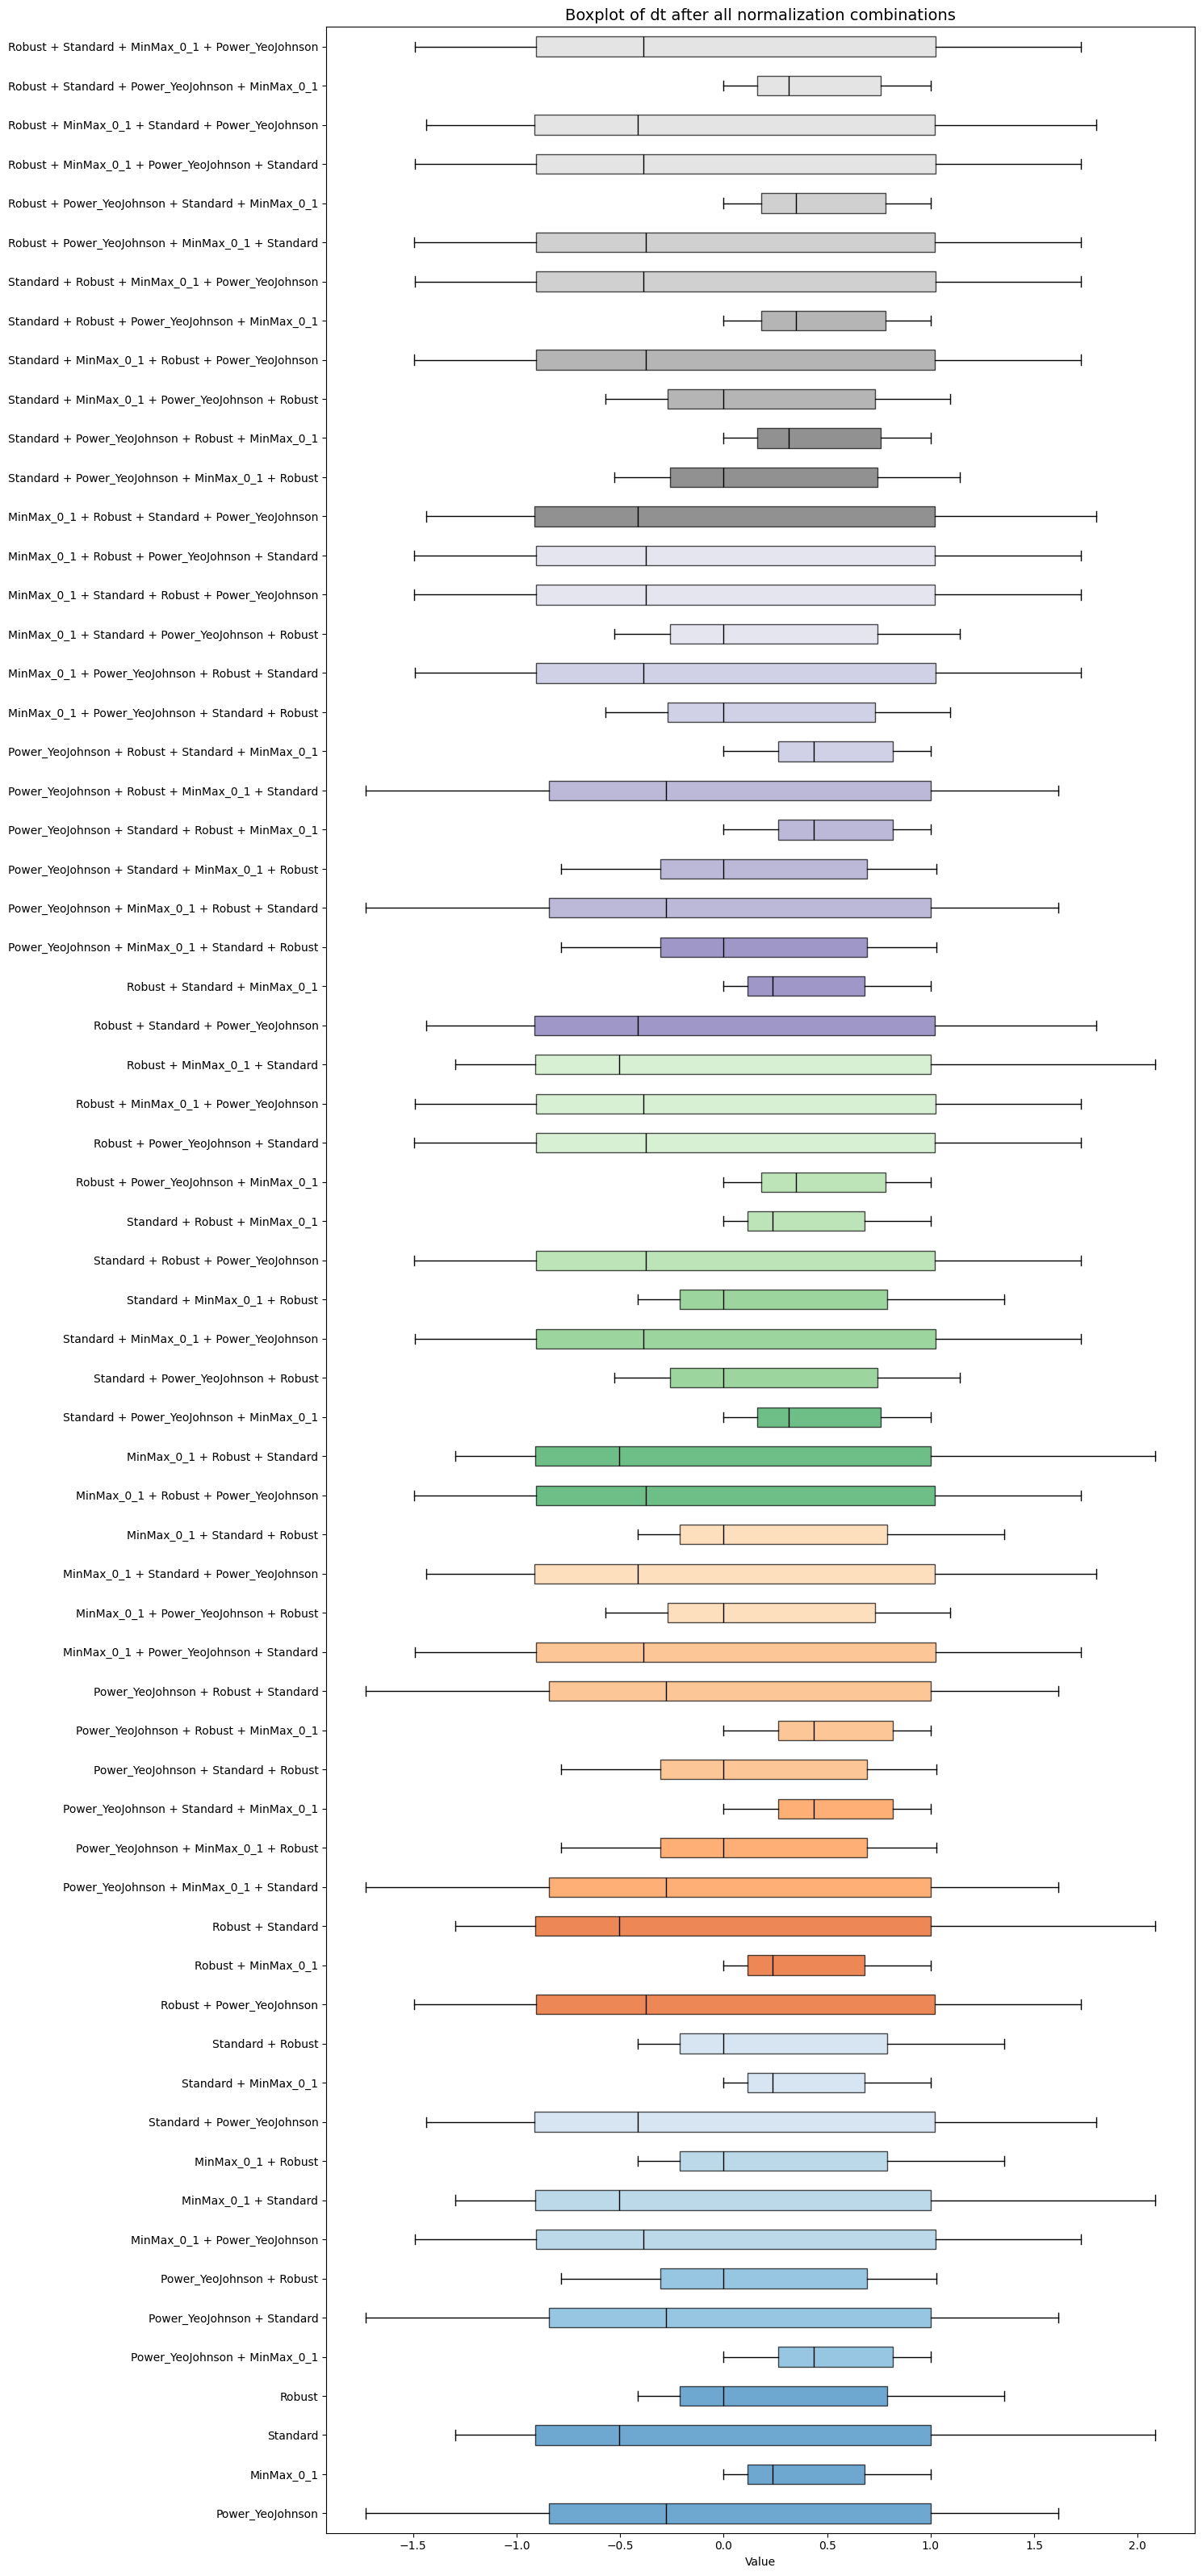

C:\Users\abolfazl\AppData\Local\Temp\ipykernel_19408\3430726732.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(results.values(), vert=False, patch_artist=True, labels=results.keys())


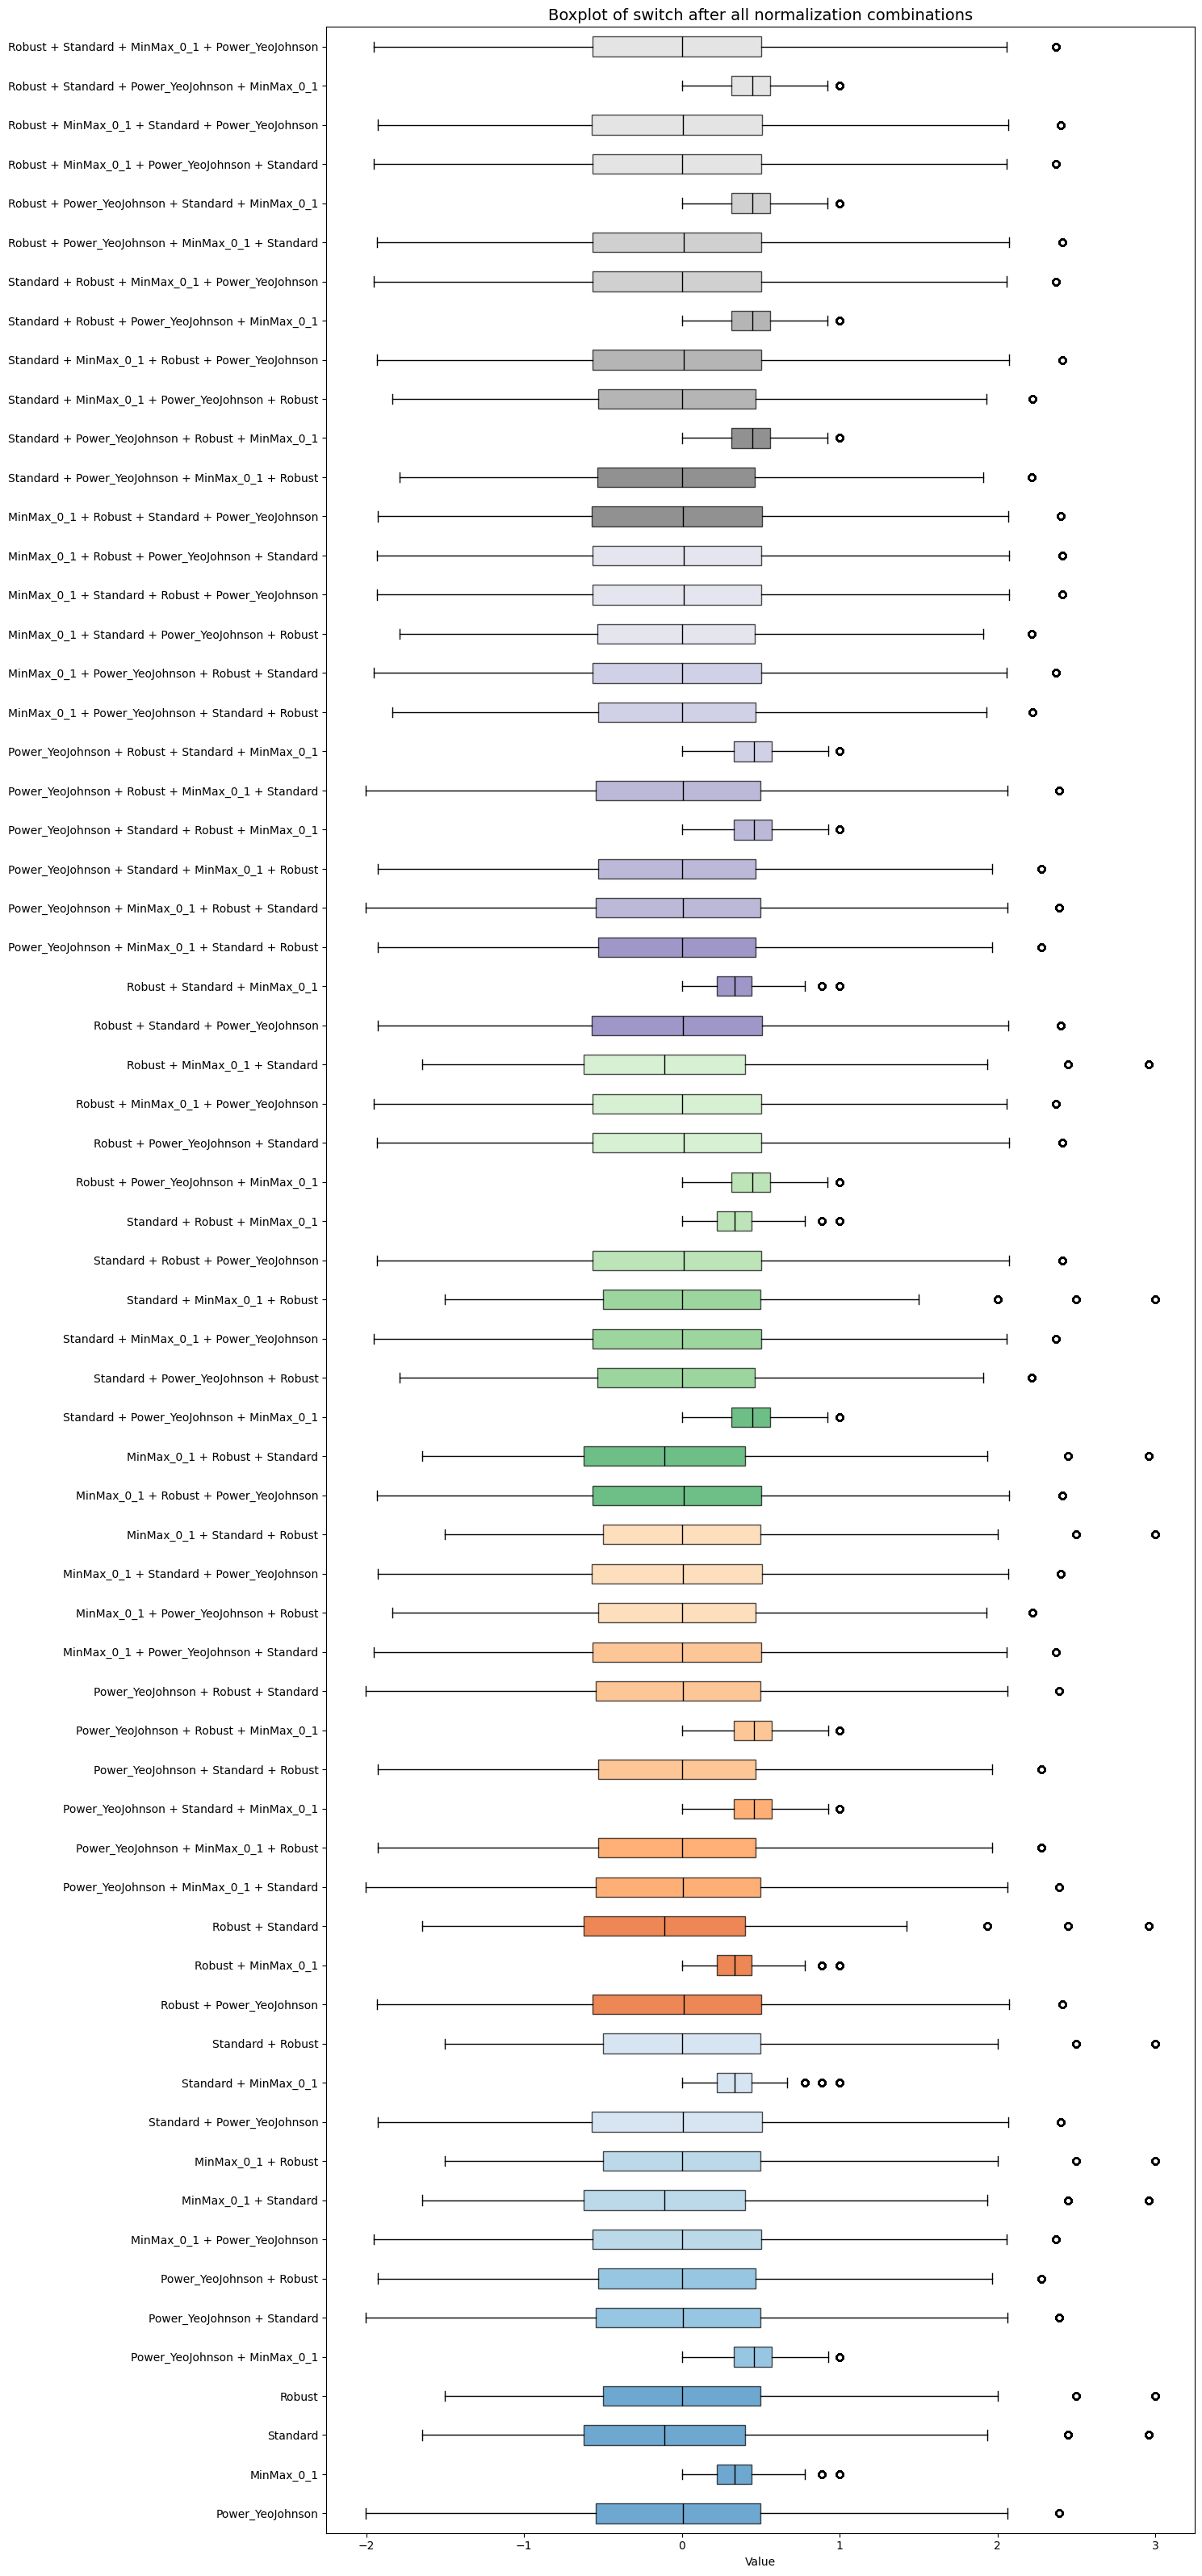

C:\Users\abolfazl\AppData\Local\Temp\ipykernel_19408\3430726732.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(results.values(), vert=False, patch_artist=True, labels=results.keys())


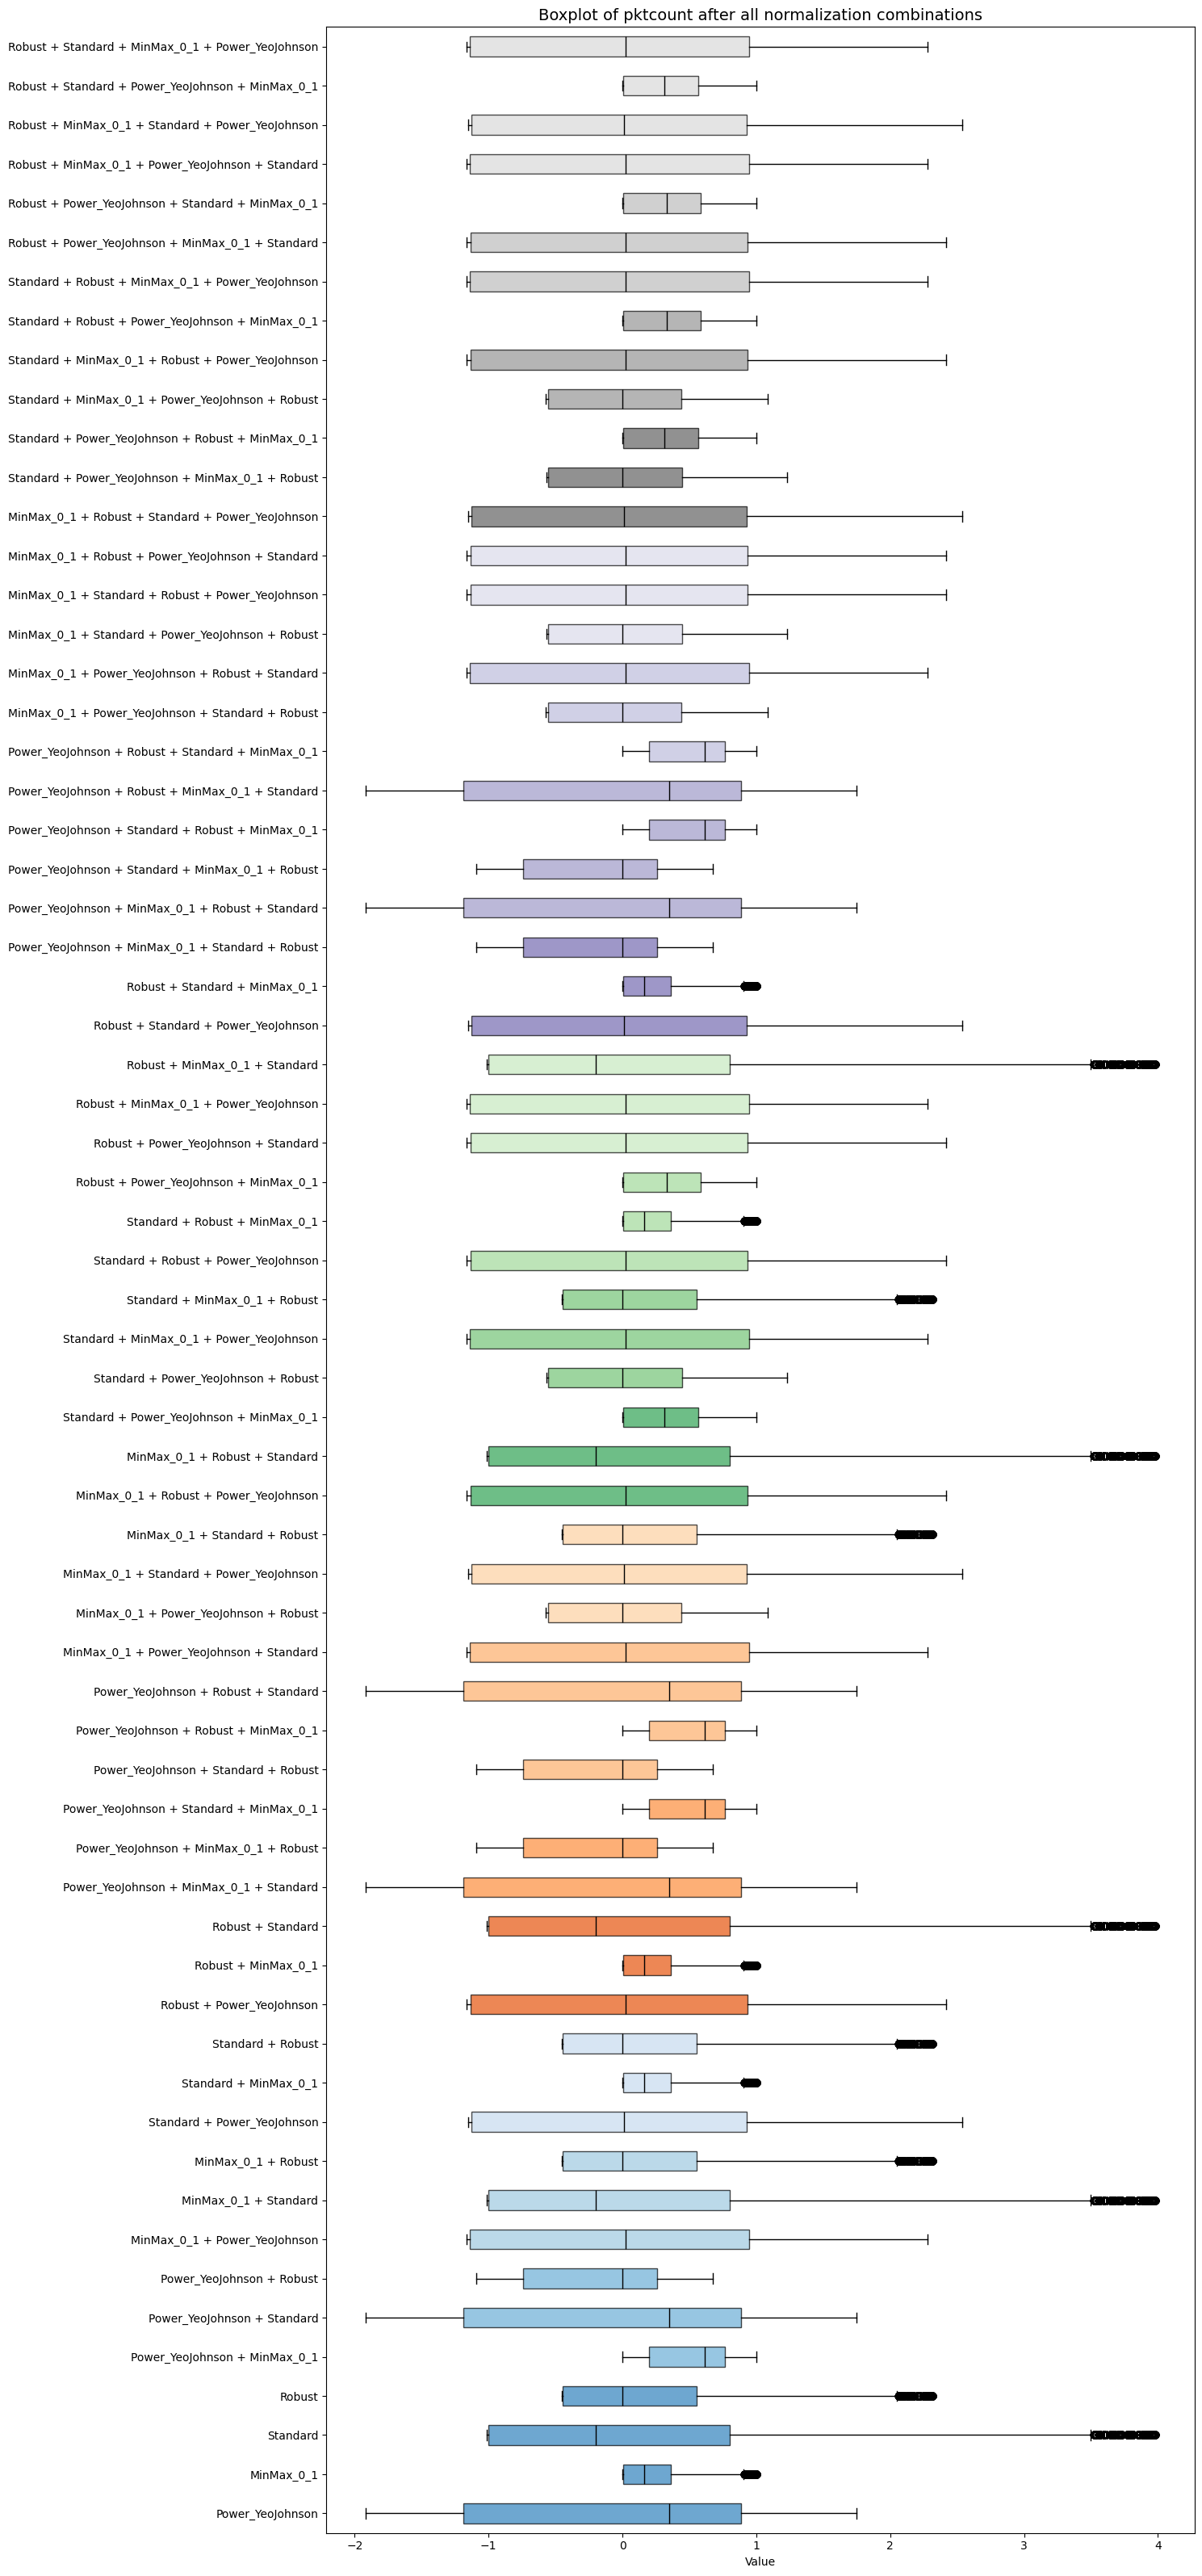

In [9]:
results = shower.Show(
    column=datasets.select_dtypes(include=['int64', 'float64']).columns
)

In [10]:
best = shower.Best(results=results)

In [11]:
best.pop("dt")
best.pop("switch")
best.pop("label")
best.pop("port_no")

'MinMax_0_1 + Power_YeoJohnson'

In [12]:
best

{'pktcount': 'MinMax_0_1',
 'bytecount': 'MinMax_0_1',
 'dur': 'Power_YeoJohnson',
 'dur_nsec': 'Power_YeoJohnson',
 'tot_dur': 'Power_YeoJohnson',
 'flows': 'Power_YeoJohnson',
 'packetins': 'Robust + Power_YeoJohnson',
 'pktperflow': 'MinMax_0_1 + Power_YeoJohnson',
 'byteperflow': 'MinMax_0_1 + Power_YeoJohnson',
 'pktrate': 'MinMax_0_1 + Power_YeoJohnson',
 'Pairflow': 'Power_YeoJohnson',
 'tx_bytes': 'Power_YeoJohnson',
 'rx_bytes': 'Power_YeoJohnson',
 'tx_kbps': 'Standard + Power_YeoJohnson',
 'rx_kbps': 'MinMax_0_1 + Power_YeoJohnson',
 'tot_kbps': 'Power_YeoJohnson'}

In [13]:
def apply_scaling(df, column, methods):

    models = [
        StandardScaler() , 
        MinMaxScaler(feature_range=(0,1)) , 
        RobustScaler() , 
        PowerTransformer(method='yeo-johnson')
    ]

    x = df[[column]].values

    for method in methods:

        method = method.strip()

        if method == 'Standard':
            x = models[0].fit_transform(x)

        elif method == 'MinMax_0_1':
            x = models[1].fit_transform(x)

        elif method == 'Robust':
            x = models[2].fit_transform(x)
            
        elif method == 'Power_YeoJohnson':
            x = models[3].fit_transform(x)
            
    df[column] = x
    return df

for col, method_str in best.items():
    methods = method_str.split('+')
    datasets = apply_scaling(datasets, col, methods)

In [14]:
datasets

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,0.174242,0.328245,-0.824396,0.922101,-0.818006,-0.991750,...,1.256894,-1.234793,UDP,3,1.025994,-1.138297,-0.596500,-0.641519,-1.003429,0
1,11605,1,10.0.0.1,10.0.0.8,0.486123,0.915781,0.144101,0.972343,0.144000,-1.753941,...,1.256894,-1.234793,UDP,4,-1.154499,-1.152968,-0.596500,-0.641519,-1.003429,0
2,11425,1,10.0.0.2,10.0.0.8,0.347427,0.654498,-0.206608,1.000032,-0.205285,-0.991750,...,1.256894,-1.234793,UDP,1,-1.156948,-1.290835,-0.596500,-0.641519,-1.003429,0
3,11425,1,10.0.0.2,10.0.0.8,0.347427,0.654498,-0.206608,1.000032,-0.205285,-0.991750,...,1.256894,-1.234793,UDP,2,-1.162637,-1.267230,-0.596500,-0.641519,-1.003429,0
4,11425,1,10.0.0.2,10.0.0.8,0.347427,0.654498,-0.206608,1.000032,-0.205285,-0.991750,...,1.256894,-1.234793,UDP,3,-1.178046,-1.147438,-0.596500,-0.641519,-1.003429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,0.000304,0.000053,-0.987457,1.263541,-0.980556,0.009951,...,-1.088812,-1.234793,ICMP,1,-0.879294,-0.969765,-0.593229,-0.639051,-0.657761,0
104341,5262,3,10.0.0.5,10.0.0.7,0.000304,0.000053,-0.987457,1.263541,-0.980556,0.009951,...,-1.088812,-1.234793,ICMP,3,-0.880753,-0.948247,-0.593229,-0.639051,-0.657761,0
104342,5262,3,10.0.0.11,10.0.0.5,0.000119,0.000021,-1.608081,1.165653,-1.592904,0.009951,...,-1.084659,-1.234793,ICMP,2,-1.178279,-1.144989,-0.596500,-0.641519,-1.003429,0
104343,5262,3,10.0.0.11,10.0.0.5,0.000119,0.000021,-1.608081,1.165653,-1.592904,0.009951,...,-1.084659,-1.234793,ICMP,1,-0.879294,-0.969765,-0.593229,-0.639051,-0.657761,0


In [15]:
from sklearn.preprocessing import LabelEncoder

datasets["label"] = np.where(
    datasets["label"] == 0,
    "BENIGN" ,
    "DDos" + "_" + datasets["Protocol"] 
)

encoder = LabelEncoder() 
datasets['label'] = encoder.fit_transform(datasets['label'])

print("Labels : " , encoder.classes_)

encoder = LabelEncoder() 
datasets['Protocol'] = encoder.fit_transform(datasets['Protocol'])

print("Protocol : " , encoder.classes_)

Labels :  ['BENIGN' 'DDos_ICMP' 'DDos_TCP' 'DDos_UDP']
Protocol :  ['ICMP' 'TCP' 'UDP']


## create graph 

In [48]:
datasets

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,dur_nsec_ratio,pkt_flow_total,byte_flow_total,tx_rx_total,tx_rx_diff,pkt_byte_total,pkt_byte_ratio,tot_kbps_weighted,pktcount_weighted,bytecount_weighted
0,11425,1,10.0.0.1,10.0.0.8,0.174242,0.328245,-0.824396,0.922101,-0.818006,-0.991750,...,5.066640,-1.244587,-1.596246,-0.112303,2.164291,0.502487,0.131182,-0.005518,9.581540e-04,1.805014e-03
1,11605,1,10.0.0.1,10.0.0.8,0.486123,0.915781,0.144101,0.972343,0.144000,-1.753941,...,0.849950,-2.199595,-2.821594,-2.307467,-0.001530,1.401905,0.253747,-0.007274,3.524218e-03,6.639081e-03
2,11425,1,10.0.0.2,10.0.0.8,0.347427,0.654498,-0.206608,1.000032,-0.205285,-0.991750,...,1.258353,-1.244376,-1.596046,-2.447783,0.133888,1.001925,0.209989,-0.007555,2.615776e-03,4.927718e-03
3,11425,1,10.0.0.2,10.0.0.8,0.347427,0.654498,-0.206608,1.000032,-0.205285,-0.991750,...,1.258353,-1.244376,-1.596046,-2.429867,0.104593,1.001925,0.209989,-0.007555,2.615776e-03,4.927718e-03
4,11425,1,10.0.0.2,10.0.0.8,0.347427,0.654498,-0.206608,1.000032,-0.205285,-0.991750,...,1.258353,-1.244376,-1.596046,-2.325485,-0.030608,1.001925,0.209989,-0.008102,2.805372e-03,5.284887e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,0.000304,0.000053,-0.987457,1.263541,-0.980556,0.009951,...,64.983489,-0.010818,-0.007718,-1.849058,0.090471,0.000356,0.000304,-0.000410,1.892964e-07,3.278358e-08
104341,5262,3,10.0.0.5,10.0.0.7,0.000304,0.000053,-0.987457,1.263541,-0.980556,0.009951,...,64.983489,-0.010818,-0.007718,-1.829000,0.067494,0.000356,0.000304,-0.000410,1.892964e-07,3.278358e-08
104342,5262,3,10.0.0.11,10.0.0.5,0.000119,0.000021,-1.608081,1.165653,-1.592904,0.009951,...,-1.966007,-0.010817,-0.007718,-2.323268,-0.033291,0.000140,0.000119,-0.003899,4.632984e-07,8.023704e-08
104343,5262,3,10.0.0.11,10.0.0.5,0.000119,0.000021,-1.608081,1.165653,-1.592904,0.009951,...,-1.966007,-0.010817,-0.007718,-1.849058,0.090471,0.000140,0.000119,-0.002556,4.632984e-07,8.023704e-08


In [17]:
datasets["node_src"] = datasets["src"].astype(str) + "_" + datasets["Protocol"].astype(str) + "_" + datasets["port_no"].astype(str) + "_" + datasets["switch"].astype(str) + "_" + datasets["label"].astype(str)
datasets["node_dst"] = datasets["dst"].astype(str) + "_" + datasets["Protocol"].astype(str) + "_" + datasets["port_no"].astype(str) + "_" + datasets["switch"].astype(str) + "_" + datasets["label"].astype(str)

In [18]:
node_feature_labels = [
    'dt' , 'switch', 'pktcount', 'bytecount', 'flows', 'packetins',
    'pktperflow', 'byteperflow', 'pktrate', 'Pairflow', 
    'Protocol', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps' , 'port_no'
]

nodes_df = pd.concat([
    datasets.rename(columns={"node_src": "node_key"}) [["node_key"] + node_feature_labels ],
    datasets.rename(columns={"node_dst": "node_key"}) [["node_key"] + node_feature_labels ]
])

In [21]:
def weighted_mean(x, w):
    return x * w

def weighted_agg(df):

    w = df['dt'] / df['dt'].sum()

    result = {
        'Protocol': df['Protocol'].iloc[0] ,
        'port_no': df['port_no'].iloc[0] ,
    }

    numeric_cols = [
        'pktcount' , 
        'bytecount' , 
        'flows' , 
        'packetins' , 
        'pktperflow' , 
        'byteperflow' , 
        'pktrate' , 
        'Pairflow' , 
        'tx_bytes' , 
        'rx_bytes' , 
        'tx_kbps' , 
        'rx_kbps' , 
        'tot_kbps'
    ] 

    for col in numeric_cols:

        _col = weighted_mean(df[col], w)

        result[f'{col}_mean'] = _col.mean()
        result[f'{col}_max'] = _col.max()
        result[f'{col}_min'] = _col.min()
        result[f'{col}_std'] = _col.std()
        result[f'{col}_sum'] = _col.sum()
        result[f'{col}_median'] = _col.median()
    
    return pd.Series(result).fillna(0)

grouped = nodes_df.groupby('node_key').apply(weighted_agg).reset_index()

C:\Users\abolfazl\AppData\Local\Temp\ipykernel_19408\3572092951.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = nodes_df.groupby('node_key').apply(weighted_agg).reset_index()


In [22]:
node_to_id = {ip: idx for idx, ip in enumerate(pd.unique(grouped["node_key"]))}

In [23]:
from tqdm import tqdm
import pandas as pd

edge_feature_labels = [   
    'pktcount',
    'bytecount',
    'dur',
    'dur_nsec',
    'tot_dur',
    'flows',
    'packetins',
    'pktperflow',
    'byteperflow',
    'pktrate',
    'Pairflow',
    'Protocol',
    'port_no',
    'tx_bytes',
    'rx_bytes',
    'tx_kbps',
    'rx_kbps',
    'tot_kbps',
    'weight' , 
    'tx_rx_ratio' , 
    'pkt_per_byte' , 
    'byteperflow_per_pktperflow' , 
    'pkt_per_flow' , 
    'byte_per_flow' , 
    'tx_tot_ratio' , 
    'rx_tot_ratio' , 
    'dur_ratio' , 
    'dur_nsec_ratio' , 
    'pkt_flow_total' , 
    'byte_flow_total' , 
    'tx_rx_total' , 
    'tx_rx_diff' , 
    'pkt_byte_total' , 
    'pkt_byte_ratio' , 
    'tot_kbps_weighted' , 
    'pktcount_weighted' , 
    'bytecount_weighted' , 
]

edges_df = pd.DataFrame({
    "src": datasets["node_src"].map(node_to_id),
    "dst": datasets["node_dst"].map(node_to_id),
    "label": datasets["label"] 
})

datasets["weight"] = datasets.groupby('node_src')['dt'].transform(lambda x: x / x.sum())

datasets['tx_rx_ratio'] =                datasets['tx_bytes']    / (datasets['rx_bytes'] + 1)
datasets['pkt_per_byte'] =               datasets['pktcount']    / (datasets['bytecount'] + 1)
datasets['byteperflow_per_pktperflow'] = datasets['byteperflow'] / (datasets['pktperflow'] + 1)
datasets['pkt_per_flow'] =               datasets['pktcount']    / (datasets['flows'] + 1)
datasets['byte_per_flow'] =              datasets['bytecount']   / (datasets['flows'] + 1)
datasets['tx_tot_ratio'] =               datasets['tx_bytes']    / (datasets['tot_kbps'] + 1)
datasets['rx_tot_ratio'] =               datasets['rx_bytes']    / (datasets['tot_kbps'] + 1)
datasets['dur_ratio'] =                  datasets['dur']         / (datasets['tot_dur'] + 1)
datasets['dur_nsec_ratio'] =             datasets['dur_nsec']    / (datasets['tot_dur'] + 1)
datasets['pkt_flow_total'] =             datasets['pktperflow']  * datasets['flows']
datasets['byte_flow_total'] =            datasets['byteperflow'] * datasets['flows']
datasets['tx_rx_total'] =                datasets['tx_bytes']    + datasets['rx_bytes']
datasets['tx_rx_diff'] =                 datasets['tx_bytes']    - datasets['rx_bytes']
datasets['pkt_byte_total'] =             datasets['pktcount']    + datasets['bytecount']
datasets['pkt_byte_ratio'] =             datasets['pktcount']    / (datasets['bytecount'] + 1)
datasets['tot_kbps_weighted'] =          datasets['tot_kbps']    * datasets['weight']
datasets['pktcount_weighted'] =          datasets['pktcount']    * datasets['weight']
datasets['bytecount_weighted'] =         datasets['bytecount']   * datasets['weight']

edge_features = datasets[edge_feature_labels].to_numpy().tolist()
edge_index = edges_df[["src", "dst"]].to_numpy().T.tolist()
edge_labels = edges_df["label"].tolist()

In [24]:
data = Data(
    x=torch.tensor(grouped.drop(columns=['node_key']).values.tolist()),
    edge_index=torch.tensor(edge_index),
    edge_attr=torch.tensor(edge_features),
    y=torch.tensor(edge_labels)
)

In [25]:
data 

Data(x=[2232, 80], edge_index=[2, 103839], edge_attr=[103839, 37], y=[103839])

## split 

In [28]:
num_edges = data.edge_index.size(1)
edge_indices = torch.arange(num_edges)

train_idx, test_idx = train_test_split(edge_indices, test_size=0.2, random_state=42, stratify=data.y)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42, stratify=data.y[test_idx])

def create_edge_split_data(data, edge_ids):
    edge_index = data.edge_index[:, edge_ids]
    edge_attr = data.edge_attr[edge_ids]
    edge_label = data.y[edge_ids]

    return Data(
        x=data.x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=edge_label
    )

data_train = create_edge_split_data(data, train_idx)
data_val   = create_edge_split_data(data, val_idx)
data_test  = create_edge_split_data(data, test_idx)

loader_train = NeighborLoader(data_train, num_neighbors=[15, 10], batch_size=1024, shuffle=True)
loader_val   = NeighborLoader(data_val, num_neighbors=[15, 10], batch_size=1024, shuffle=False)
loader_test  = NeighborLoader(data_test, num_neighbors=[15, 10], batch_size=1024, shuffle=False)


## model 

In [29]:
class EdgeAwareGNNLayerLSTM(MessagePassing):
    def __init__(self, node_in, edge_in, hidden_dim):
        super().__init__(aggr='add')
        self.hidden_dim = hidden_dim

        self.node_proj = Linear(node_in, hidden_dim)
        self.edge_proj = Linear(edge_in, hidden_dim)

        self.update_rnn = LSTM(hidden_dim, hidden_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.node_proj(x)
        edge_attr = self.edge_proj(edge_attr)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out, x):
        out, self._hidden_state = self.update_rnn(aggr_out.unsqueeze(0))
        return out.squeeze(0)

class GCTLayer(torch.nn.Module):
    def __init__(self, in_channels_node: int, in_channels_edge: int, out_channels: int):
        super().__init__()
        self.node_proj = Linear(in_channels_node, out_channels)
        self.edge_proj = Linear(in_channels_edge, out_channels)

        self._attn = nn.Sequential(
            Linear(3 * out_channels, 1 , bias=False) , 
            nn.LeakyReLU(negative_slope=0.2)
        )

        self._output = nn.ReLU() 

        self._update = nn.Sequential(
            Linear(3 * out_channels, out_channels) , 
            nn.ReLU() 
        )

    def __massage__(self , attn : torch.Tensor , x_j : torch.Tensor , edge_proj : torch.Tensor , x_proj : torch.Tensor , row : torch.Tensor ): 
        x_out = torch.zeros_like(x_proj)
        x_out.index_add_(
            0, 
            row, 
            attn * (x_j + edge_proj) 
        )

        return self._output(x_out) 

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor):
        
        x_proj = self.node_proj(x)
        edge_proj = self.edge_proj(edge_attr)

        row, col = edge_index
        x_i, x_j = x_proj[row], x_proj[col]

        attn = softmax(
            self._attn(
                torch.cat([x_i, x_j, edge_proj], dim=-1)
            ), 
            row
        )

        node_attr = self.__massage__(
            attn=attn , x_j=x_j , edge_proj=edge_proj , x_proj=x_proj , row=row
        )

        edge_attr = self._update(
            torch.cat([x_i, x_j, edge_proj], dim=-1)
        )

        return node_attr, edge_attr
    
class GCTNetwork(torch.nn.Module):
    """
    GCTNetwork: A multi-layer GCT-based network for node classification.
    """
    def __init__(self, node_dim: int, edge_dim: int, hidden_dim: int , edge_classes : int):
        super().__init__()

        self.layers = nn.ModuleList([
            GCTLayer(node_dim, edge_dim, hidden_dim) , 
            GCTLayer(hidden_dim, hidden_dim, hidden_dim) , 
        ])

        self._lstm = EdgeAwareGNNLayerLSTM(node_in=hidden_dim, edge_in=hidden_dim, hidden_dim=hidden_dim)

        self._attn = GATv2Conv(hidden_dim, hidden_dim, edge_dim=hidden_dim , heads=1)

        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_classes , bias=False)
        )

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor):

        for layer in self.layers:
            x, edge_attr = layer(x, edge_index, edge_attr)

        x = self._lstm(
            x=x , edge_index=edge_index , edge_attr=edge_attr
        )

        x = self._attn(
            x= x, 
            edge_index=edge_index , 
            edge_attr= edge_attr
        )

        src, dst = edge_index

        return self.edge_mlp(torch.cat([x[src], x[dst]], dim=-1))  


In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):

        log_probs = F.log_softmax(inputs, dim=-1)
        probs = torch.exp(log_probs)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(-1))

        focal_term = (1 - probs) ** self.gamma
        loss = -self.alpha * focal_term * targets_one_hot * log_probs
        loss = loss.sum(dim=1)

        return loss.mean()


In [31]:
data

Data(x=[2232, 80], edge_index=[2, 103839], edge_attr=[103839, 37], y=[103839])

In [42]:
device = torch.device('cuda')
model = GCTNetwork(node_dim=80 , edge_dim=37 , hidden_dim=768 , edge_classes=len(Counter(data.y.tolist()))).to(device)
# loss_func = FocalLoss().to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters() , lr=0.0001)

## train 

In [43]:
bestmodel = 0
num_epochs = 100

train_loss_all = []
train_acc_all = []

test_loss_all = []
test_acc_all = []

for epoch in range(num_epochs):

    _acctrain = []
    _acctest = []

    model.train()

    for graph in (_descript := tqdm(loader_train)):

        optimizer.zero_grad()

        outputs = model( graph.x.to(device) ,  graph.edge_index.to(device), graph.edge_attr.to(device) )

        loss = loss_func(outputs, graph.y.to(device) )

        acc = (outputs.argmax(dim=-1).eq(graph.y.to(device)).sum().item() / outputs.size(0)) * 100 

        loss.backward()
        optimizer.step() 

        _descript.set_description(f"loss : {loss.item():.4f} , acc : {acc:.4f}")

        train_loss_all.append(loss.item())
        train_acc_all.append(acc)
        _acctrain.append(acc)

    model.eval() 
    with torch.no_grad():

        for graph in (_descript := tqdm(loader_val)):

            outputs = model( graph.x.to(device) ,  graph.edge_index.to(device), graph.edge_attr.to(device) )

            loss = loss_func(outputs, graph.y.to(device) )

            acc = (outputs.argmax(dim=-1).eq(graph.y.to(device)).sum().item() / outputs.size(0)) * 100 

            _descript.set_description(f"Test => epoch : {epoch + 1 } , loss : {loss.item():.4f} , acc : {acc:.4f}")

            test_loss_all.append(loss.item())
            test_acc_all.append(acc)
            _acctest.append(acc)

    print(f"Epoch : {epoch} , Accurecy Train : {sum(_acctrain) / len(_acctrain) :.4f} , Accurecy Test : {sum(_acctest) / len(_acctest) :.4f} ")


loss : 1.1413 , acc : 58.9213: 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]
Test => epoch : 1 , loss : 1.0778 , acc : 71.2142: 100%|██████████| 3/3 [00:00<00:00, 104.74it/s]


Epoch : 0 , Accurecy Train : 55.5678 , Accurecy Test : 65.9040 


loss : 0.9686 , acc : 59.7779: 100%|██████████| 3/3 [00:00<00:00, 23.36it/s]
Test => epoch : 2 , loss : 0.9128 , acc : 70.8108: 100%|██████████| 3/3 [00:00<00:00, 106.13it/s]


Epoch : 1 , Accurecy Train : 57.3956 , Accurecy Test : 67.1443 


loss : 0.8596 , acc : 61.6196: 100%|██████████| 3/3 [00:00<00:00, 23.72it/s]
Test => epoch : 3 , loss : 0.8185 , acc : 71.4350: 100%|██████████| 3/3 [00:00<00:00, 106.68it/s]


Epoch : 2 , Accurecy Train : 61.8447 , Accurecy Test : 67.3195 


loss : 0.7803 , acc : 68.1499: 100%|██████████| 3/3 [00:00<00:00, 23.65it/s]
Test => epoch : 4 , loss : 0.8128 , acc : 72.9512: 100%|██████████| 3/3 [00:00<00:00, 102.94it/s]


Epoch : 3 , Accurecy Train : 65.2129 , Accurecy Test : 70.6721 


loss : 0.7526 , acc : 69.4344: 100%|██████████| 3/3 [00:00<00:00, 23.60it/s]
Test => epoch : 5 , loss : 0.7919 , acc : 75.3728: 100%|██████████| 3/3 [00:00<00:00, 97.48it/s]


Epoch : 4 , Accurecy Train : 71.6031 , Accurecy Test : 72.3965 


loss : 0.6931 , acc : 76.7161: 100%|██████████| 3/3 [00:00<00:00, 23.44it/s]
Test => epoch : 6 , loss : 0.7693 , acc : 76.1559: 100%|██████████| 3/3 [00:00<00:00, 103.02it/s]


Epoch : 5 , Accurecy Train : 75.3086 , Accurecy Test : 74.3766 


loss : 0.7563 , acc : 69.9081: 100%|██████████| 3/3 [00:00<00:00, 23.43it/s]
Test => epoch : 7 , loss : 0.7002 , acc : 76.2765: 100%|██████████| 3/3 [00:00<00:00, 105.14it/s]


Epoch : 6 , Accurecy Train : 74.5554 , Accurecy Test : 73.7508 


loss : 0.6510 , acc : 77.4790: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 8 , loss : 0.6925 , acc : 77.7627: 100%|██████████| 3/3 [00:00<00:00, 103.09it/s]


Epoch : 7 , Accurecy Train : 79.0577 , Accurecy Test : 74.6603 


loss : 0.6754 , acc : 72.5011: 100%|██████████| 3/3 [00:00<00:00, 23.53it/s]
Test => epoch : 9 , loss : 0.6423 , acc : 77.6682: 100%|██████████| 3/3 [00:00<00:00, 104.60it/s]


Epoch : 8 , Accurecy Train : 78.4150 , Accurecy Test : 75.2820 


loss : 0.5831 , acc : 78.7423: 100%|██████████| 3/3 [00:00<00:00, 23.46it/s]
Test => epoch : 10 , loss : 0.6310 , acc : 78.2451: 100%|██████████| 3/3 [00:00<00:00, 107.14it/s]


Epoch : 9 , Accurecy Train : 80.7195 , Accurecy Test : 76.3877 


loss : 0.5469 , acc : 78.5794: 100%|██████████| 3/3 [00:00<00:00, 23.31it/s]
Test => epoch : 11 , loss : 0.5782 , acc : 79.0455: 100%|██████████| 3/3 [00:00<00:00, 104.32it/s]


Epoch : 10 , Accurecy Train : 81.3598 , Accurecy Test : 76.5913 


loss : 0.4593 , acc : 81.8436: 100%|██████████| 3/3 [00:00<00:00, 23.62it/s]
Test => epoch : 12 , loss : 0.5989 , acc : 79.8270: 100%|██████████| 3/3 [00:00<00:00, 105.71it/s]


Epoch : 11 , Accurecy Train : 82.6573 , Accurecy Test : 78.1103 


loss : 0.5705 , acc : 76.1216: 100%|██████████| 3/3 [00:00<00:00, 23.86it/s]
Test => epoch : 13 , loss : 0.5681 , acc : 82.0134: 100%|██████████| 3/3 [00:00<00:00, 102.04it/s]


Epoch : 12 , Accurecy Train : 81.7566 , Accurecy Test : 78.6263 


loss : 0.4768 , acc : 82.9558: 100%|██████████| 3/3 [00:00<00:00, 23.72it/s]
Test => epoch : 14 , loss : 0.5877 , acc : 84.2318: 100%|██████████| 3/3 [00:00<00:00, 106.64it/s]


Epoch : 13 , Accurecy Train : 84.8216 , Accurecy Test : 79.9175 


loss : 0.4811 , acc : 82.9202: 100%|██████████| 3/3 [00:00<00:00, 23.42it/s]
Test => epoch : 15 , loss : 0.5348 , acc : 83.0470: 100%|██████████| 3/3 [00:00<00:00, 106.19it/s]


Epoch : 14 , Accurecy Train : 84.6582 , Accurecy Test : 80.7473 


loss : 0.4983 , acc : 79.6865: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 16 , loss : 0.5219 , acc : 84.3891: 100%|██████████| 3/3 [00:00<00:00, 108.85it/s]


Epoch : 15 , Accurecy Train : 84.7064 , Accurecy Test : 81.6787 


loss : 0.3840 , acc : 85.5408: 100%|██████████| 3/3 [00:00<00:00, 23.46it/s]
Test => epoch : 17 , loss : 0.5150 , acc : 82.0869: 100%|██████████| 3/3 [00:00<00:00, 102.41it/s]


Epoch : 16 , Accurecy Train : 85.0795 , Accurecy Test : 80.3096 


loss : 0.3795 , acc : 85.6180: 100%|██████████| 3/3 [00:00<00:00, 23.44it/s]
Test => epoch : 18 , loss : 0.5039 , acc : 82.4379: 100%|██████████| 3/3 [00:00<00:00, 108.29it/s]


Epoch : 17 , Accurecy Train : 86.7432 , Accurecy Test : 81.8321 


loss : 0.4874 , acc : 78.5980: 100%|██████████| 3/3 [00:00<00:00, 23.74it/s]
Test => epoch : 19 , loss : 0.4981 , acc : 83.4383: 100%|██████████| 3/3 [00:00<00:00, 107.47it/s]


Epoch : 18 , Accurecy Train : 83.4309 , Accurecy Test : 81.0048 


loss : 0.3527 , acc : 85.3274: 100%|██████████| 3/3 [00:00<00:00, 23.50it/s]
Test => epoch : 20 , loss : 0.4605 , acc : 86.0788: 100%|██████████| 3/3 [00:00<00:00, 101.91it/s]


Epoch : 19 , Accurecy Train : 85.5776 , Accurecy Test : 83.8399 


loss : 0.3707 , acc : 87.7942: 100%|██████████| 3/3 [00:00<00:00, 23.40it/s]
Test => epoch : 21 , loss : 0.4702 , acc : 83.3636: 100%|██████████| 3/3 [00:00<00:00, 100.35it/s]


Epoch : 20 , Accurecy Train : 87.6315 , Accurecy Test : 82.8609 


loss : 0.3741 , acc : 84.1320: 100%|██████████| 3/3 [00:00<00:00, 23.43it/s]
Test => epoch : 22 , loss : 0.4502 , acc : 85.9665: 100%|██████████| 3/3 [00:00<00:00, 106.24it/s]


Epoch : 21 , Accurecy Train : 87.3366 , Accurecy Test : 83.7966 


loss : 0.3455 , acc : 87.1541: 100%|██████████| 3/3 [00:00<00:00, 23.54it/s]
Test => epoch : 23 , loss : 0.4045 , acc : 86.6184: 100%|██████████| 3/3 [00:00<00:00, 107.05it/s]


Epoch : 22 , Accurecy Train : 88.0232 , Accurecy Test : 85.0727 


loss : 0.2914 , acc : 90.0929: 100%|██████████| 3/3 [00:00<00:00, 23.46it/s]
Test => epoch : 24 , loss : 0.3992 , acc : 87.5952: 100%|██████████| 3/3 [00:00<00:00, 106.35it/s]


Epoch : 23 , Accurecy Train : 90.1661 , Accurecy Test : 85.2450 


loss : 0.4101 , acc : 84.5235: 100%|██████████| 3/3 [00:00<00:00, 23.85it/s]
Test => epoch : 25 , loss : 0.4364 , acc : 85.5275: 100%|██████████| 3/3 [00:00<00:00, 106.42it/s]


Epoch : 24 , Accurecy Train : 88.8392 , Accurecy Test : 84.6689 


loss : 0.3076 , acc : 86.9045: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 26 , loss : 0.3858 , acc : 86.6426: 100%|██████████| 3/3 [00:00<00:00, 104.11it/s]


Epoch : 25 , Accurecy Train : 90.0050 , Accurecy Test : 85.7981 


loss : 0.3617 , acc : 85.0845: 100%|██████████| 3/3 [00:00<00:00, 23.54it/s]
Test => epoch : 27 , loss : 0.3490 , acc : 89.9008: 100%|██████████| 3/3 [00:00<00:00, 108.22it/s]


Epoch : 26 , Accurecy Train : 89.4931 , Accurecy Test : 87.6089 


loss : 0.2474 , acc : 91.0774: 100%|██████████| 3/3 [00:00<00:00, 23.75it/s]
Test => epoch : 28 , loss : 0.3281 , acc : 87.9692: 100%|██████████| 3/3 [00:00<00:00, 107.46it/s]


Epoch : 27 , Accurecy Train : 91.1587 , Accurecy Test : 87.3382 


loss : 0.3056 , acc : 89.4771: 100%|██████████| 3/3 [00:00<00:00, 23.39it/s]
Test => epoch : 29 , loss : 0.3235 , acc : 87.8366: 100%|██████████| 3/3 [00:00<00:00, 108.09it/s]


Epoch : 28 , Accurecy Train : 91.3175 , Accurecy Test : 86.3697 


loss : 0.2710 , acc : 90.4190: 100%|██████████| 3/3 [00:00<00:00, 23.39it/s]
Test => epoch : 30 , loss : 0.2715 , acc : 92.2589: 100%|██████████| 3/3 [00:00<00:00, 106.13it/s]


Epoch : 29 , Accurecy Train : 91.6629 , Accurecy Test : 88.4603 


loss : 0.3555 , acc : 85.9549: 100%|██████████| 3/3 [00:00<00:00, 23.78it/s]
Test => epoch : 31 , loss : 0.2873 , acc : 90.5363: 100%|██████████| 3/3 [00:00<00:00, 104.91it/s]


Epoch : 30 , Accurecy Train : 90.8808 , Accurecy Test : 88.9933 


loss : 0.2787 , acc : 88.9160: 100%|██████████| 3/3 [00:00<00:00, 23.62it/s]
Test => epoch : 32 , loss : 0.2969 , acc : 91.8736: 100%|██████████| 3/3 [00:00<00:00, 105.83it/s]


Epoch : 31 , Accurecy Train : 92.1947 , Accurecy Test : 88.4824 


loss : 0.2065 , acc : 90.9736: 100%|██████████| 3/3 [00:00<00:00, 23.65it/s]
Test => epoch : 33 , loss : 0.2792 , acc : 92.8119: 100%|██████████| 3/3 [00:00<00:00, 106.36it/s]


Epoch : 32 , Accurecy Train : 92.8091 , Accurecy Test : 90.3999 


loss : 0.2677 , acc : 89.7317: 100%|██████████| 3/3 [00:00<00:00, 23.81it/s]
Test => epoch : 34 , loss : 0.2596 , acc : 91.0388: 100%|██████████| 3/3 [00:00<00:00, 102.06it/s]


Epoch : 33 , Accurecy Train : 93.0910 , Accurecy Test : 89.6542 


loss : 0.2631 , acc : 90.4436: 100%|██████████| 3/3 [00:00<00:00, 23.73it/s]
Test => epoch : 35 , loss : 0.2620 , acc : 91.4080: 100%|██████████| 3/3 [00:00<00:00, 105.71it/s]


Epoch : 34 , Accurecy Train : 92.7918 , Accurecy Test : 89.8276 


loss : 0.1590 , acc : 94.8023: 100%|██████████| 3/3 [00:00<00:00, 23.24it/s]
Test => epoch : 36 , loss : 0.2387 , acc : 91.7341: 100%|██████████| 3/3 [00:00<00:00, 104.38it/s]


Epoch : 35 , Accurecy Train : 94.8284 , Accurecy Test : 90.7444 


loss : 0.2477 , acc : 89.0553: 100%|██████████| 3/3 [00:00<00:00, 23.60it/s]
Test => epoch : 37 , loss : 0.2780 , acc : 90.0635: 100%|██████████| 3/3 [00:00<00:00, 100.41it/s]


Epoch : 36 , Accurecy Train : 92.9358 , Accurecy Test : 89.2286 


loss : 0.2153 , acc : 90.6835: 100%|██████████| 3/3 [00:00<00:00, 23.70it/s]
Test => epoch : 38 , loss : 0.2596 , acc : 92.8251: 100%|██████████| 3/3 [00:00<00:00, 99.31it/s]


Epoch : 37 , Accurecy Train : 93.6332 , Accurecy Test : 90.8208 


loss : 0.2549 , acc : 88.2757: 100%|██████████| 3/3 [00:00<00:00, 23.33it/s]
Test => epoch : 39 , loss : 0.2005 , acc : 94.1603: 100%|██████████| 3/3 [00:00<00:00, 108.09it/s]


Epoch : 38 , Accurecy Train : 93.2641 , Accurecy Test : 91.1946 


loss : 0.1958 , acc : 93.8468: 100%|██████████| 3/3 [00:00<00:00, 23.16it/s]
Test => epoch : 40 , loss : 0.2294 , acc : 92.3879: 100%|██████████| 3/3 [00:00<00:00, 101.29it/s]


Epoch : 39 , Accurecy Train : 95.1453 , Accurecy Test : 90.8573 


loss : 0.2662 , acc : 89.7653: 100%|██████████| 3/3 [00:00<00:00, 23.92it/s]
Test => epoch : 41 , loss : 0.2314 , acc : 94.5813: 100%|██████████| 3/3 [00:00<00:00, 109.04it/s]


Epoch : 40 , Accurecy Train : 93.1158 , Accurecy Test : 91.6002 


loss : 0.2219 , acc : 90.7902: 100%|██████████| 3/3 [00:00<00:00, 23.26it/s]
Test => epoch : 42 , loss : 0.2189 , acc : 91.3082: 100%|██████████| 3/3 [00:00<00:00, 99.70it/s]


Epoch : 41 , Accurecy Train : 94.4008 , Accurecy Test : 90.5026 


loss : 0.2120 , acc : 92.5348: 100%|██████████| 3/3 [00:00<00:00, 23.85it/s]
Test => epoch : 43 , loss : 0.2211 , acc : 94.3182: 100%|██████████| 3/3 [00:00<00:00, 104.76it/s]


Epoch : 42 , Accurecy Train : 94.2413 , Accurecy Test : 92.0839 


loss : 0.1922 , acc : 92.9111: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 44 , loss : 0.2166 , acc : 93.6393: 100%|██████████| 3/3 [00:00<00:00, 107.78it/s]


Epoch : 43 , Accurecy Train : 94.6971 , Accurecy Test : 92.3268 


loss : 0.1740 , acc : 94.0493: 100%|██████████| 3/3 [00:00<00:00, 23.34it/s]
Test => epoch : 45 , loss : 0.2191 , acc : 91.2670: 100%|██████████| 3/3 [00:00<00:00, 105.37it/s]


Epoch : 44 , Accurecy Train : 94.6999 , Accurecy Test : 91.9273 


loss : 0.2279 , acc : 90.1918: 100%|██████████| 3/3 [00:00<00:00, 23.77it/s]
Test => epoch : 46 , loss : 0.1492 , acc : 95.8730: 100%|██████████| 3/3 [00:00<00:00, 104.93it/s]


Epoch : 45 , Accurecy Train : 93.7021 , Accurecy Test : 92.2218 


loss : 0.1669 , acc : 93.1244: 100%|██████████| 3/3 [00:00<00:00, 23.73it/s]
Test => epoch : 47 , loss : 0.1470 , acc : 95.9405: 100%|██████████| 3/3 [00:00<00:00, 108.38it/s]


Epoch : 46 , Accurecy Train : 95.2059 , Accurecy Test : 94.1916 


loss : 0.2006 , acc : 90.3527: 100%|██████████| 3/3 [00:00<00:00, 23.65it/s]
Test => epoch : 48 , loss : 0.1907 , acc : 94.1336: 100%|██████████| 3/3 [00:00<00:00, 107.16it/s]


Epoch : 47 , Accurecy Train : 93.9587 , Accurecy Test : 93.1052 


loss : 0.1871 , acc : 92.8423: 100%|██████████| 3/3 [00:00<00:00, 23.01it/s]
Test => epoch : 49 , loss : 0.2029 , acc : 91.7374: 100%|██████████| 3/3 [00:00<00:00, 112.47it/s]


Epoch : 48 , Accurecy Train : 95.0656 , Accurecy Test : 90.5316 


loss : 0.1468 , acc : 93.2055: 100%|██████████| 3/3 [00:00<00:00, 23.64it/s]
Test => epoch : 50 , loss : 0.1927 , acc : 92.7149: 100%|██████████| 3/3 [00:00<00:00, 102.93it/s]


Epoch : 49 , Accurecy Train : 94.0447 , Accurecy Test : 90.0926 


loss : 0.1360 , acc : 93.7856: 100%|██████████| 3/3 [00:00<00:00, 23.83it/s]
Test => epoch : 51 , loss : 0.1517 , acc : 93.8545: 100%|██████████| 3/3 [00:00<00:00, 105.90it/s]


Epoch : 50 , Accurecy Train : 94.1543 , Accurecy Test : 92.8543 


loss : 0.2350 , acc : 90.3319: 100%|██████████| 3/3 [00:00<00:00, 23.74it/s]
Test => epoch : 52 , loss : 0.1515 , acc : 95.2403: 100%|██████████| 3/3 [00:00<00:00, 104.69it/s]


Epoch : 51 , Accurecy Train : 93.6992 , Accurecy Test : 91.6554 


loss : 0.1712 , acc : 94.3291: 100%|██████████| 3/3 [00:00<00:00, 23.60it/s]
Test => epoch : 53 , loss : 0.1901 , acc : 94.6092: 100%|██████████| 3/3 [00:00<00:00, 109.77it/s]


Epoch : 52 , Accurecy Train : 93.9972 , Accurecy Test : 93.3963 


loss : 0.1633 , acc : 94.3103: 100%|██████████| 3/3 [00:00<00:00, 23.51it/s]
Test => epoch : 54 , loss : 0.1780 , acc : 95.0901: 100%|██████████| 3/3 [00:00<00:00, 107.90it/s]


Epoch : 53 , Accurecy Train : 95.8572 , Accurecy Test : 92.7669 


loss : 0.2932 , acc : 87.9724: 100%|██████████| 3/3 [00:00<00:00, 23.56it/s]
Test => epoch : 55 , loss : 0.1632 , acc : 93.3544: 100%|██████████| 3/3 [00:00<00:00, 104.09it/s]


Epoch : 54 , Accurecy Train : 93.6518 , Accurecy Test : 91.6854 


loss : 0.1535 , acc : 92.9139: 100%|██████████| 3/3 [00:00<00:00, 23.39it/s]
Test => epoch : 56 , loss : 0.1819 , acc : 94.3456: 100%|██████████| 3/3 [00:00<00:00, 102.97it/s]


Epoch : 55 , Accurecy Train : 94.1102 , Accurecy Test : 92.8261 


loss : 0.1329 , acc : 94.0175: 100%|██████████| 3/3 [00:00<00:00, 23.61it/s]
Test => epoch : 57 , loss : 0.1669 , acc : 94.5569: 100%|██████████| 3/3 [00:00<00:00, 103.06it/s]


Epoch : 56 , Accurecy Train : 95.9897 , Accurecy Test : 92.8806 


loss : 0.1443 , acc : 94.8586: 100%|██████████| 3/3 [00:00<00:00, 23.23it/s]
Test => epoch : 58 , loss : 0.1373 , acc : 97.1933: 100%|██████████| 3/3 [00:00<00:00, 100.91it/s]


Epoch : 57 , Accurecy Train : 96.5259 , Accurecy Test : 94.5293 


loss : 0.1406 , acc : 94.6951: 100%|██████████| 3/3 [00:00<00:00, 23.27it/s]
Test => epoch : 59 , loss : 0.1340 , acc : 96.0163: 100%|██████████| 3/3 [00:00<00:00, 103.44it/s]


Epoch : 58 , Accurecy Train : 96.2416 , Accurecy Test : 93.2158 


loss : 0.1088 , acc : 96.1700: 100%|██████████| 3/3 [00:00<00:00, 23.50it/s]
Test => epoch : 60 , loss : 0.1539 , acc : 94.5970: 100%|██████████| 3/3 [00:00<00:00, 101.95it/s]


Epoch : 59 , Accurecy Train : 96.2559 , Accurecy Test : 93.6914 


loss : 0.1608 , acc : 93.2188: 100%|██████████| 3/3 [00:00<00:00, 23.48it/s]
Test => epoch : 61 , loss : 0.1850 , acc : 94.6842: 100%|██████████| 3/3 [00:00<00:00, 106.46it/s]


Epoch : 60 , Accurecy Train : 95.5673 , Accurecy Test : 93.6631 


loss : 0.1327 , acc : 94.9203: 100%|██████████| 3/3 [00:00<00:00, 23.52it/s]
Test => epoch : 62 , loss : 0.1812 , acc : 94.0992: 100%|██████████| 3/3 [00:00<00:00, 105.93it/s]


Epoch : 61 , Accurecy Train : 96.5409 , Accurecy Test : 94.6928 


loss : 0.1194 , acc : 95.2349: 100%|██████████| 3/3 [00:00<00:00, 23.31it/s]
Test => epoch : 63 , loss : 0.1632 , acc : 95.8942: 100%|██████████| 3/3 [00:00<00:00, 99.25it/s]


Epoch : 62 , Accurecy Train : 96.3265 , Accurecy Test : 94.2705 


loss : 0.2061 , acc : 92.1390: 100%|██████████| 3/3 [00:00<00:00, 23.28it/s]
Test => epoch : 64 , loss : 0.1236 , acc : 95.6698: 100%|██████████| 3/3 [00:00<00:00, 105.05it/s]


Epoch : 63 , Accurecy Train : 95.1904 , Accurecy Test : 94.2138 


loss : 0.2169 , acc : 91.5021: 100%|██████████| 3/3 [00:00<00:00, 23.54it/s]
Test => epoch : 65 , loss : 0.1540 , acc : 94.6437: 100%|██████████| 3/3 [00:00<00:00, 96.96it/s]


Epoch : 64 , Accurecy Train : 94.8637 , Accurecy Test : 93.3421 


loss : 0.0986 , acc : 96.6913: 100%|██████████| 3/3 [00:00<00:00, 23.30it/s]
Test => epoch : 66 , loss : 0.1485 , acc : 96.8536: 100%|██████████| 3/3 [00:00<00:00, 101.79it/s]


Epoch : 65 , Accurecy Train : 96.7460 , Accurecy Test : 94.6230 


loss : 0.1055 , acc : 95.9857: 100%|██████████| 3/3 [00:00<00:00, 23.33it/s]
Test => epoch : 67 , loss : 0.1322 , acc : 95.7447: 100%|██████████| 3/3 [00:00<00:00, 106.17it/s]


Epoch : 66 , Accurecy Train : 96.7027 , Accurecy Test : 94.1592 


loss : 0.1674 , acc : 93.8866: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 68 , loss : 0.1334 , acc : 96.5331: 100%|██████████| 3/3 [00:00<00:00, 105.49it/s]


Epoch : 67 , Accurecy Train : 95.7780 , Accurecy Test : 94.7159 


loss : 0.1275 , acc : 94.1938: 100%|██████████| 3/3 [00:00<00:00, 23.52it/s]
Test => epoch : 69 , loss : 0.1664 , acc : 94.0385: 100%|██████████| 3/3 [00:00<00:00, 102.69it/s]


Epoch : 68 , Accurecy Train : 96.5189 , Accurecy Test : 93.8696 


loss : 0.1055 , acc : 95.5237: 100%|██████████| 3/3 [00:00<00:00, 23.98it/s]
Test => epoch : 70 , loss : 0.1356 , acc : 96.5440: 100%|██████████| 3/3 [00:00<00:00, 103.21it/s]


Epoch : 69 , Accurecy Train : 95.9724 , Accurecy Test : 95.1941 


loss : 0.1070 , acc : 96.3922: 100%|██████████| 3/3 [00:00<00:00, 23.34it/s]
Test => epoch : 71 , loss : 0.1293 , acc : 95.2788: 100%|██████████| 3/3 [00:00<00:00, 101.05it/s]


Epoch : 70 , Accurecy Train : 97.3289 , Accurecy Test : 94.1110 


loss : 0.1513 , acc : 94.6688: 100%|██████████| 3/3 [00:00<00:00, 23.85it/s]
Test => epoch : 72 , loss : 0.1495 , acc : 95.2467: 100%|██████████| 3/3 [00:00<00:00, 100.95it/s]


Epoch : 71 , Accurecy Train : 96.0532 , Accurecy Test : 94.0958 


loss : 0.1796 , acc : 90.8510: 100%|██████████| 3/3 [00:00<00:00, 23.74it/s]
Test => epoch : 73 , loss : 0.1745 , acc : 93.9257: 100%|██████████| 3/3 [00:00<00:00, 105.55it/s]


Epoch : 72 , Accurecy Train : 94.7218 , Accurecy Test : 94.5701 


loss : 0.1158 , acc : 94.5203: 100%|██████████| 3/3 [00:00<00:00, 23.32it/s]
Test => epoch : 74 , loss : 0.0927 , acc : 96.4075: 100%|██████████| 3/3 [00:00<00:00, 103.90it/s]


Epoch : 73 , Accurecy Train : 96.2265 , Accurecy Test : 94.9815 


loss : 0.1845 , acc : 92.4179: 100%|██████████| 3/3 [00:00<00:00, 23.36it/s]
Test => epoch : 75 , loss : 0.1366 , acc : 95.6211: 100%|██████████| 3/3 [00:00<00:00, 99.52it/s]


Epoch : 74 , Accurecy Train : 95.6978 , Accurecy Test : 93.6176 


loss : 0.1711 , acc : 94.6200: 100%|██████████| 3/3 [00:00<00:00, 23.46it/s]
Test => epoch : 76 , loss : 0.1357 , acc : 97.1599: 100%|██████████| 3/3 [00:00<00:00, 98.09it/s]


Epoch : 75 , Accurecy Train : 96.4183 , Accurecy Test : 95.3291 


loss : 0.1372 , acc : 95.4596: 100%|██████████| 3/3 [00:00<00:00, 23.44it/s]
Test => epoch : 77 , loss : 0.1321 , acc : 96.6908: 100%|██████████| 3/3 [00:00<00:00, 105.89it/s]


Epoch : 76 , Accurecy Train : 96.2482 , Accurecy Test : 94.3350 


loss : 0.1309 , acc : 94.7045: 100%|██████████| 3/3 [00:00<00:00, 23.73it/s]
Test => epoch : 78 , loss : 0.1481 , acc : 95.1780: 100%|██████████| 3/3 [00:00<00:00, 100.30it/s]


Epoch : 77 , Accurecy Train : 96.4769 , Accurecy Test : 94.8232 


loss : 0.1066 , acc : 95.3695: 100%|██████████| 3/3 [00:00<00:00, 23.50it/s]
Test => epoch : 79 , loss : 0.1266 , acc : 96.9049: 100%|██████████| 3/3 [00:00<00:00, 104.28it/s]


Epoch : 78 , Accurecy Train : 96.9741 , Accurecy Test : 95.2565 


loss : 0.1284 , acc : 96.0446: 100%|██████████| 3/3 [00:00<00:00, 23.53it/s]
Test => epoch : 80 , loss : 0.1328 , acc : 96.8989: 100%|██████████| 3/3 [00:00<00:00, 106.60it/s]


Epoch : 79 , Accurecy Train : 97.3127 , Accurecy Test : 95.0145 


loss : 0.1474 , acc : 94.0711: 100%|██████████| 3/3 [00:00<00:00, 23.72it/s]
Test => epoch : 81 , loss : 0.1074 , acc : 96.5750: 100%|██████████| 3/3 [00:00<00:00, 105.06it/s]


Epoch : 80 , Accurecy Train : 96.1394 , Accurecy Test : 94.4932 


loss : 0.1575 , acc : 94.6804: 100%|██████████| 3/3 [00:00<00:00, 23.34it/s]
Test => epoch : 82 , loss : 0.1060 , acc : 97.3507: 100%|██████████| 3/3 [00:00<00:00, 105.47it/s]


Epoch : 81 , Accurecy Train : 96.4087 , Accurecy Test : 95.1557 


loss : 0.1386 , acc : 94.9384: 100%|██████████| 3/3 [00:00<00:00, 23.69it/s]
Test => epoch : 83 , loss : 0.1301 , acc : 96.5843: 100%|██████████| 3/3 [00:00<00:00, 104.88it/s]


Epoch : 82 , Accurecy Train : 96.6808 , Accurecy Test : 96.0432 


loss : 0.1301 , acc : 94.7924: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 84 , loss : 0.1543 , acc : 91.6516: 100%|██████████| 3/3 [00:00<00:00, 106.29it/s]


Epoch : 83 , Accurecy Train : 96.6460 , Accurecy Test : 92.9912 


loss : 0.0988 , acc : 96.5490: 100%|██████████| 3/3 [00:00<00:00, 23.28it/s]
Test => epoch : 85 , loss : 0.1345 , acc : 96.1139: 100%|██████████| 3/3 [00:00<00:00, 102.89it/s]


Epoch : 84 , Accurecy Train : 96.5576 , Accurecy Test : 95.9366 


loss : 0.1215 , acc : 94.9417: 100%|██████████| 3/3 [00:00<00:00, 23.51it/s]
Test => epoch : 86 , loss : 0.1361 , acc : 96.5626: 100%|██████████| 3/3 [00:00<00:00, 106.98it/s]


Epoch : 85 , Accurecy Train : 96.9510 , Accurecy Test : 95.8347 


loss : 0.1045 , acc : 96.0641: 100%|██████████| 3/3 [00:00<00:00, 23.67it/s]
Test => epoch : 87 , loss : 0.1468 , acc : 94.6493: 100%|██████████| 3/3 [00:00<00:00, 104.48it/s]


Epoch : 86 , Accurecy Train : 97.4493 , Accurecy Test : 94.7645 


loss : 0.0843 , acc : 96.2870: 100%|██████████| 3/3 [00:00<00:00, 23.47it/s]
Test => epoch : 88 , loss : 0.1318 , acc : 95.0181: 100%|██████████| 3/3 [00:00<00:00, 104.63it/s]


Epoch : 87 , Accurecy Train : 97.3436 , Accurecy Test : 95.0673 


loss : 0.1215 , acc : 93.9799: 100%|██████████| 3/3 [00:00<00:00, 23.77it/s]
Test => epoch : 89 , loss : 0.1395 , acc : 92.4125: 100%|██████████| 3/3 [00:00<00:00, 102.49it/s]


Epoch : 88 , Accurecy Train : 96.7029 , Accurecy Test : 94.2911 


loss : 0.1082 , acc : 95.8042: 100%|██████████| 3/3 [00:00<00:00, 23.85it/s]
Test => epoch : 90 , loss : 0.1376 , acc : 95.4853: 100%|██████████| 3/3 [00:00<00:00, 102.35it/s]


Epoch : 89 , Accurecy Train : 97.1425 , Accurecy Test : 94.2101 


loss : 0.1766 , acc : 93.1382: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 91 , loss : 0.0873 , acc : 96.0899: 100%|██████████| 3/3 [00:00<00:00, 104.56it/s]


Epoch : 90 , Accurecy Train : 96.3561 , Accurecy Test : 95.4569 


loss : 0.1263 , acc : 92.8411: 100%|██████████| 3/3 [00:00<00:00, 23.60it/s]
Test => epoch : 92 , loss : 0.1139 , acc : 96.6440: 100%|██████████| 3/3 [00:00<00:00, 103.85it/s]


Epoch : 91 , Accurecy Train : 96.3844 , Accurecy Test : 95.9894 


loss : 0.1218 , acc : 93.6686: 100%|██████████| 3/3 [00:00<00:00, 23.48it/s]
Test => epoch : 93 , loss : 0.1581 , acc : 95.0701: 100%|██████████| 3/3 [00:00<00:00, 100.72it/s]


Epoch : 92 , Accurecy Train : 96.4972 , Accurecy Test : 95.3779 


loss : 0.0995 , acc : 95.5860: 100%|██████████| 3/3 [00:00<00:00, 23.34it/s]
Test => epoch : 94 , loss : 0.1458 , acc : 95.6522: 100%|██████████| 3/3 [00:00<00:00, 106.91it/s]


Epoch : 93 , Accurecy Train : 97.2340 , Accurecy Test : 95.6822 


loss : 0.0957 , acc : 96.3746: 100%|██████████| 3/3 [00:00<00:00, 23.72it/s]
Test => epoch : 95 , loss : 0.1219 , acc : 96.1504: 100%|██████████| 3/3 [00:00<00:00, 99.47it/s]


Epoch : 94 , Accurecy Train : 97.5700 , Accurecy Test : 95.9262 


loss : 0.1313 , acc : 93.9483: 100%|██████████| 3/3 [00:00<00:00, 23.73it/s]
Test => epoch : 96 , loss : 0.1370 , acc : 95.1383: 100%|██████████| 3/3 [00:00<00:00, 106.70it/s]


Epoch : 95 , Accurecy Train : 96.5474 , Accurecy Test : 95.1287 


loss : 0.1284 , acc : 94.0097: 100%|██████████| 3/3 [00:00<00:00, 23.52it/s]
Test => epoch : 97 , loss : 0.1343 , acc : 95.6679: 100%|██████████| 3/3 [00:00<00:00, 103.20it/s]


Epoch : 96 , Accurecy Train : 96.4307 , Accurecy Test : 95.4918 


loss : 0.1018 , acc : 96.1298: 100%|██████████| 3/3 [00:00<00:00, 23.70it/s]
Test => epoch : 98 , loss : 0.1308 , acc : 95.5394: 100%|██████████| 3/3 [00:00<00:00, 102.80it/s]


Epoch : 97 , Accurecy Train : 96.9612 , Accurecy Test : 94.9911 


loss : 0.0956 , acc : 96.2260: 100%|██████████| 3/3 [00:00<00:00, 23.32it/s]
Test => epoch : 99 , loss : 0.1199 , acc : 96.9314: 100%|██████████| 3/3 [00:00<00:00, 107.58it/s]


Epoch : 98 , Accurecy Train : 97.2464 , Accurecy Test : 95.3478 


loss : 0.0839 , acc : 96.9727: 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]
Test => epoch : 100 , loss : 0.0988 , acc : 96.6833: 100%|██████████| 3/3 [00:00<00:00, 107.60it/s]

Epoch : 99 , Accurecy Train : 97.1825 , Accurecy Test : 95.0318 


## predict 

In [44]:
def Test(model , test_loader , device ):
    list_predict = []
    list_target = []

    model.eval() 

    for graph in (_descript := tqdm(test_loader)):

        with torch.no_grad(): 
            
            outputs = model( graph.x.to(device) ,  graph.edge_index.to(device), graph.edge_attr.to(device) )

        list_predict += outputs.argmax(dim=-1).cpu().tolist()
        list_target += graph.y.cpu().tolist()

    return list_predict , list_target 

list_predict , list_target = Test(model , loader_test , "cuda")

100%|██████████| 3/3 [00:00<00:00, 113.26it/s]


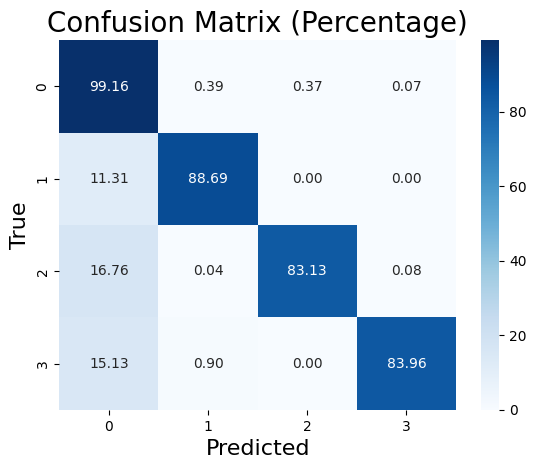

In [45]:
cm = confusion_matrix(list_target, list_predict)

cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

# plt.figure(figsize=(5,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues")

plt.title('Confusion Matrix (Percentage)', fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


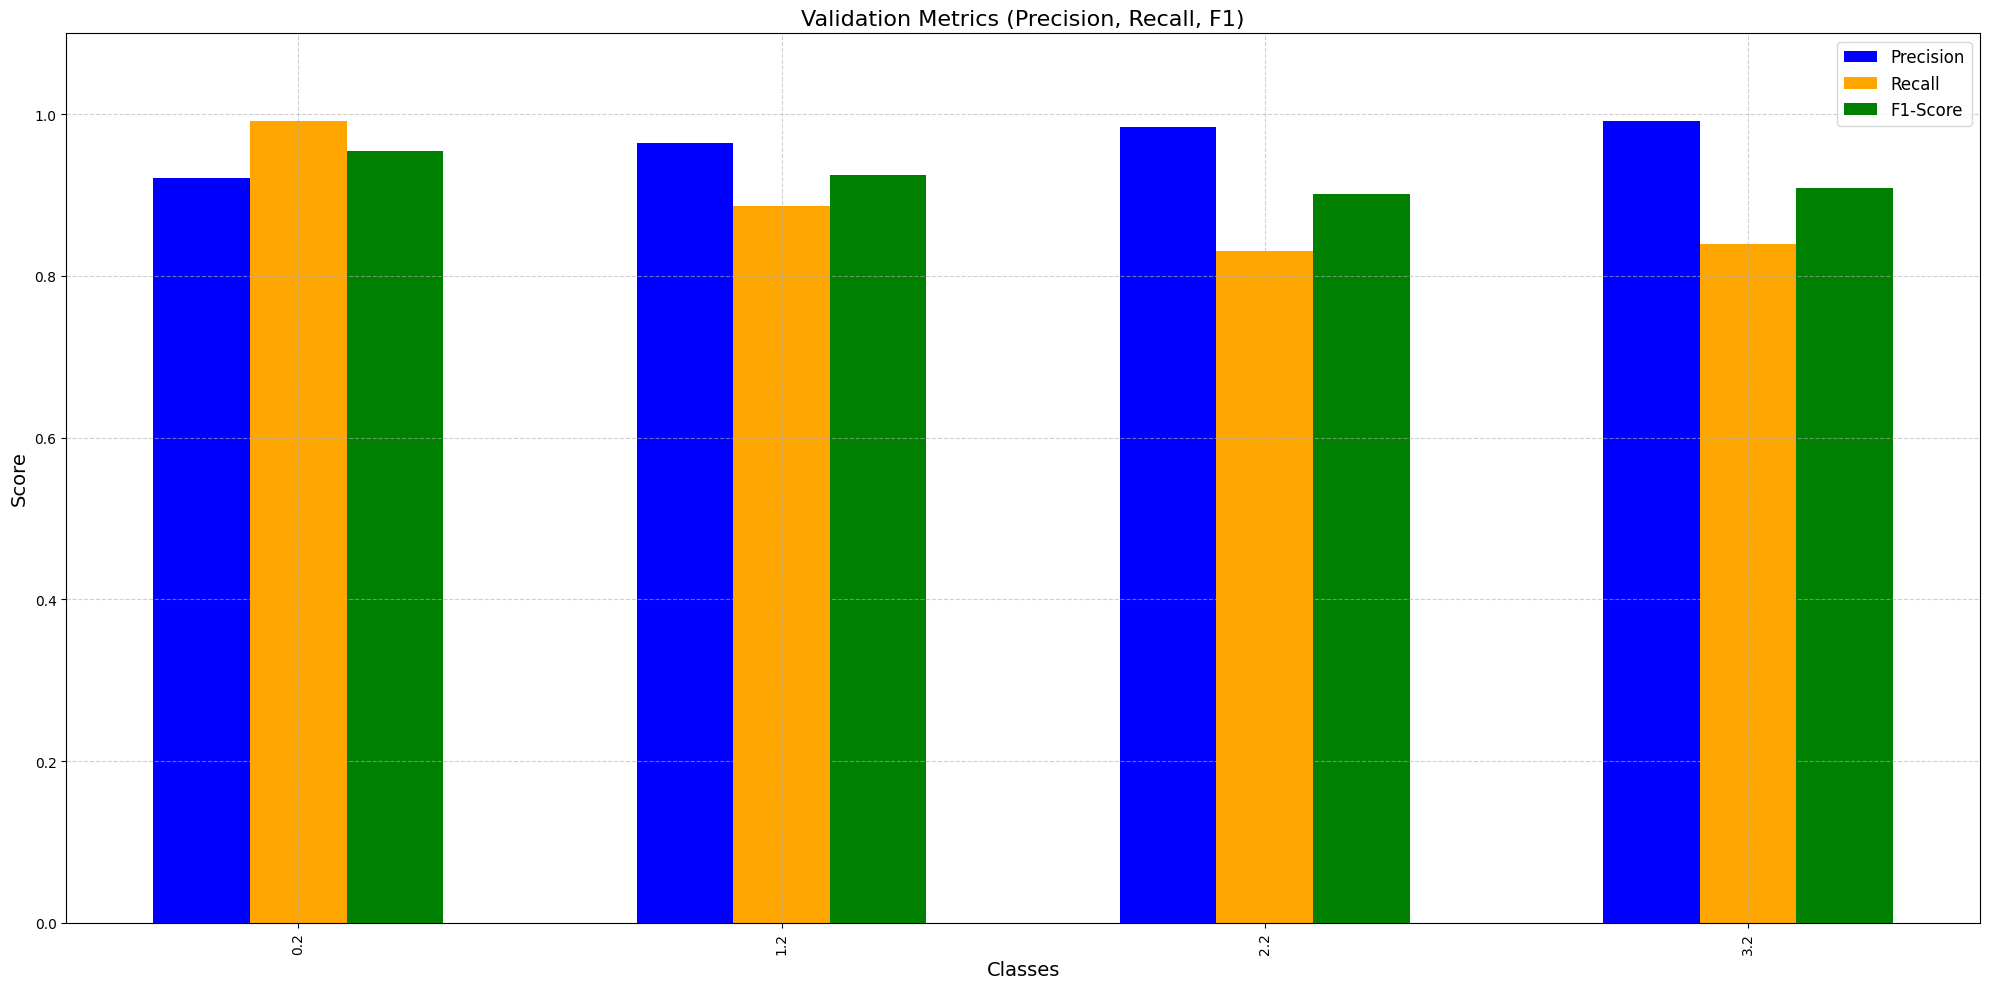

In [46]:
precision, recall, f1, _ = precision_recall_fscore_support(list_target, list_predict, average=None)

classes = list(set(list_target)) 

x = range(len(classes))

plt.figure(figsize=(20, 10))

plt.bar(x, precision, width=0.2, label="Precision", color='blue', align='center')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label="Recall", color='orange', align='center')
plt.bar([i + 0.4 for i in x], f1, width=0.2, label="F1-Score", color='green', align='center')

plt.title("Validation Metrics (Precision, Recall, F1)", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks([i + 0.2 for i in x], rotation=90 )  
plt.ylim(0, 1.1)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


In [47]:
print(classification_report(
    list_target, list_predict
))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9339
           1       0.96      0.89      0.92      1485
           2       0.98      0.83      0.90      2649
           3       0.99      0.84      0.91      1216

    accuracy                           0.94     14689
   macro avg       0.97      0.89      0.92     14689
weighted avg       0.94      0.94      0.94     14689



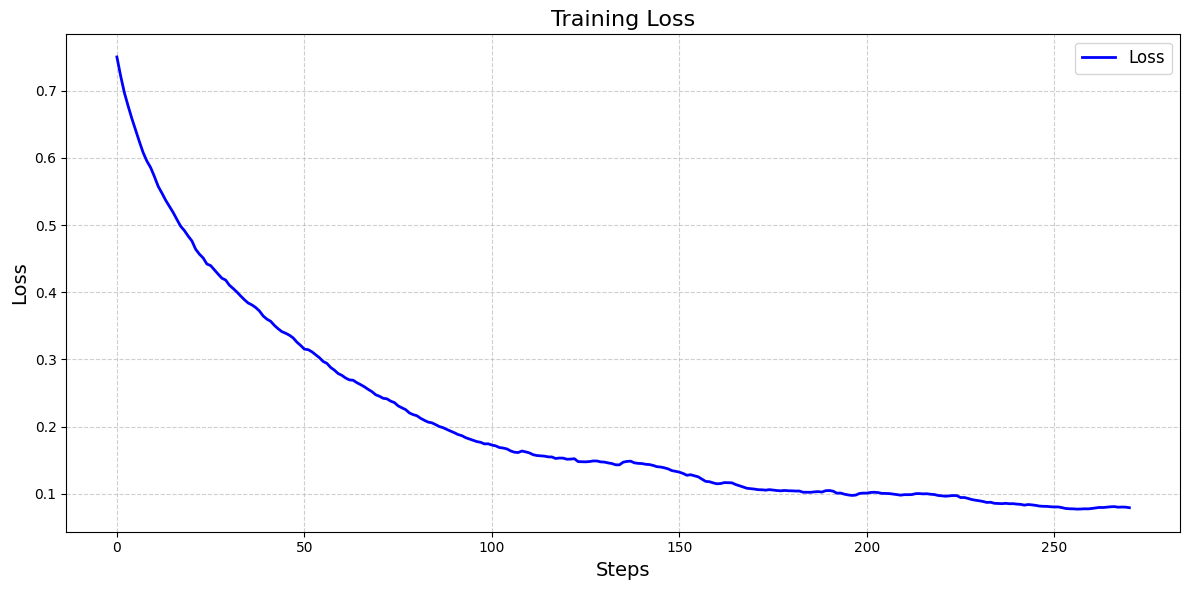

In [49]:
all_losses = np.array(train_loss_all)

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(moving_average(all_losses, window_size=30) , label="Loss", color="blue", linewidth=2)

plt.title("Training Loss", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

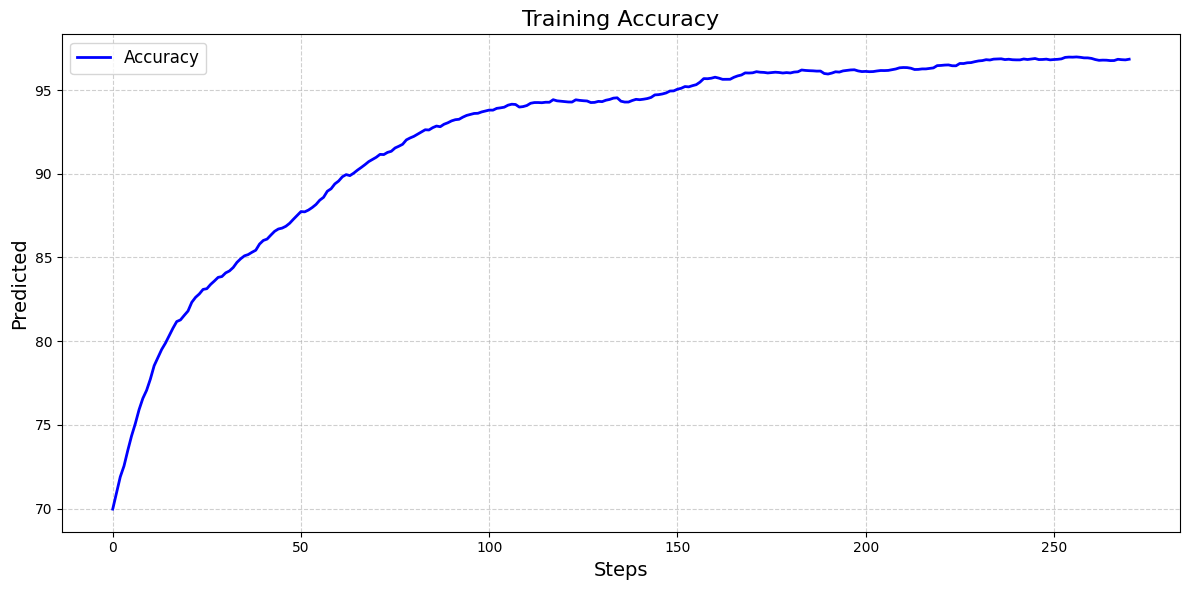

In [50]:
all_losses = np.array(train_acc_all)

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(moving_average(all_losses, window_size=30) , label="Accuracy", color="blue", linewidth=2)

plt.title("Training Accuracy", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

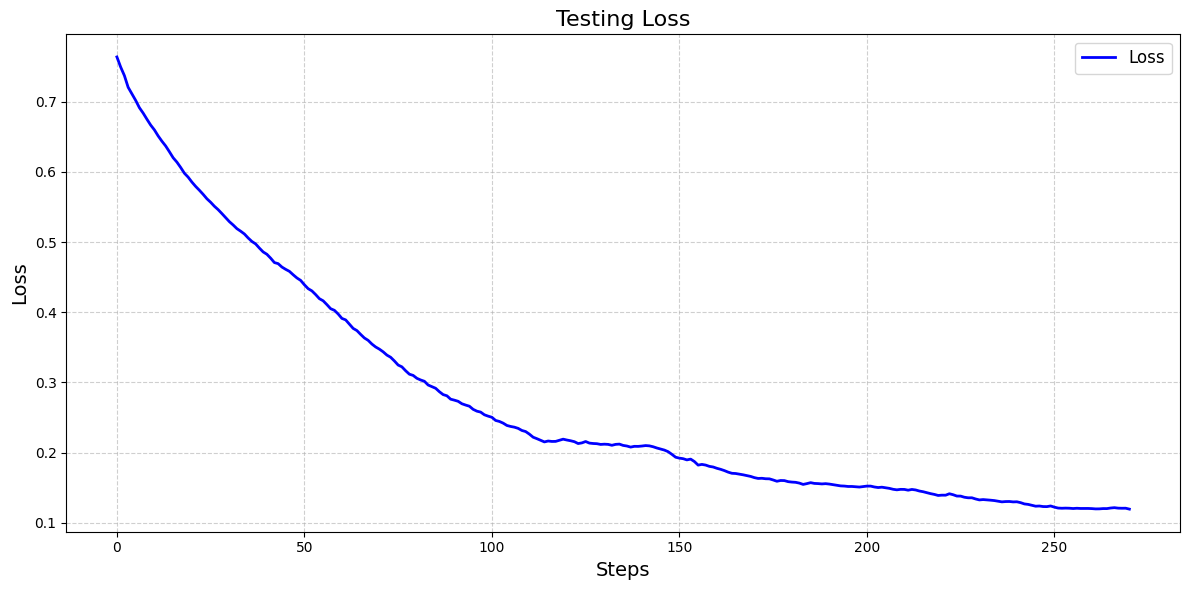

In [51]:
all_losses = np.array(test_loss_all)

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(moving_average(all_losses, window_size=30) , label="Loss", color="blue", linewidth=2)

plt.title("Testing Loss", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

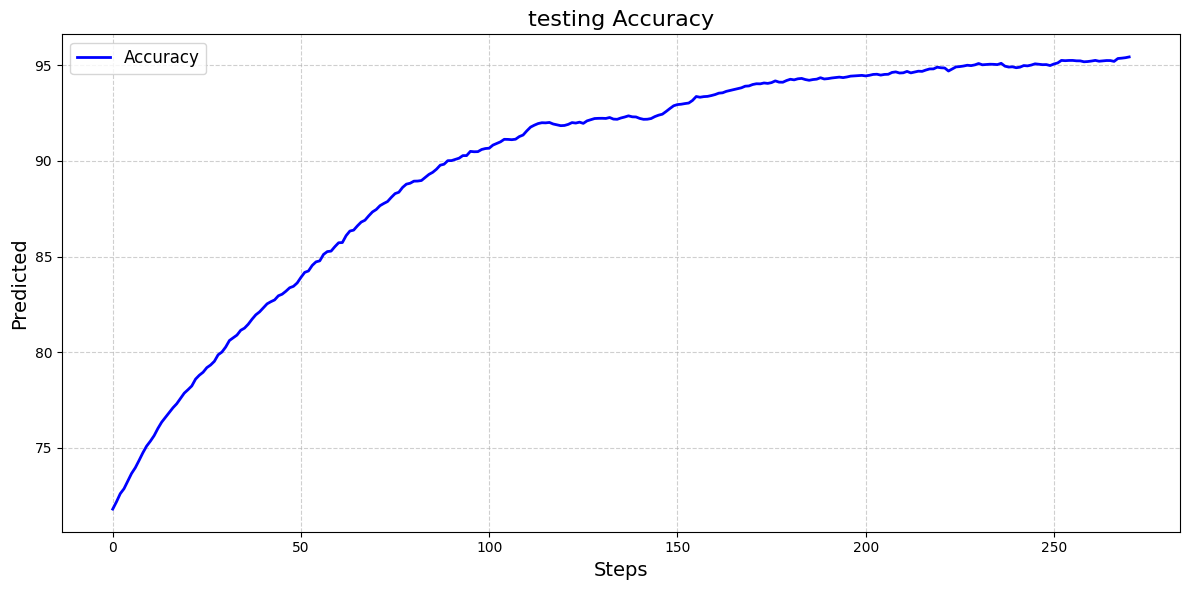

In [52]:

all_losses = np.array(test_acc_all)

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(moving_average(all_losses, window_size=30) , label="Accuracy", color="blue", linewidth=2)

plt.title("testing Accuracy", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [53]:
print( "Accurecy Test : " , (((torch.tensor(list_target) == torch.tensor(list_predict)).sum() / len(list_predict) ) * 100).item() ) 

Accurecy Test :  93.95465850830078


In [54]:
def Test(model, test_loader, device):
    list_predict = []
    list_target = []

    model.eval()

    for graph in (_descript := tqdm(test_loader)):
        with torch.no_grad():
            outputs = model(
                graph.x.to(device),
                graph.edge_index.to(device),
                graph.edge_attr.to(device)
            )

        probs = F.softmax(outputs, dim=-1)  

        list_predict += probs.cpu().tolist()     
        list_target += graph.y.cpu().tolist()

    return list_predict, list_target

list_predict , list_target = Test(model , loader_test , "cuda")

100%|██████████| 3/3 [00:00<00:00, 12.09it/s]


In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

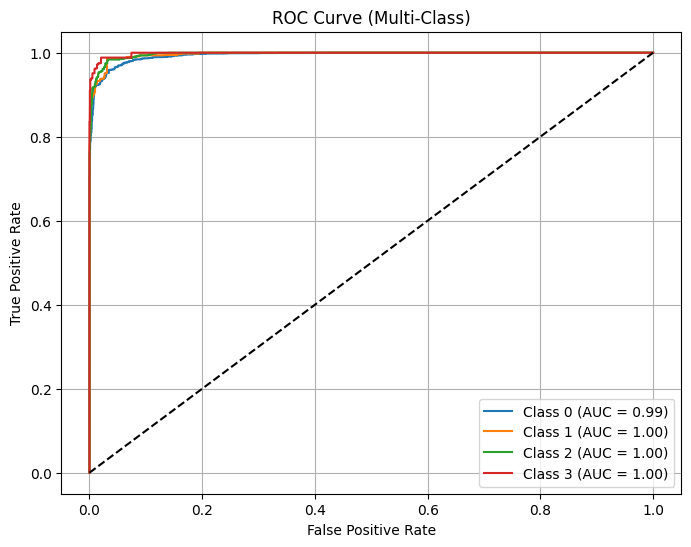

In [57]:
y_true = np.array(list_target)
y_score = np.array(list_predict)

n_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-Class)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(model.state_dict() , "./model_ddos_1.pt")